# Abdul Haseeb - 17132
# Farjad Ahmed Siddiqui – 29405
# Machine Learning - I (75767/40243)
# Term Project

### Pipeline Support Functions & Master Function

In [1]:
# Importing Depedencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis, jarque_bera
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from tabulate import tabulate
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import KMeansSMOTE

In [2]:
# Support Function

# Data Fetching Function
def get_data(direc):
    direc=input("Please enter the source path: ")
    df=pd.read_csv(direc)
    return df

# Missing Values Treatment
def missing_value_treatment(df):
    missing_columns=df.columns[df.isna().any()].tolist()
    numerical_cols=df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols=list(set(df.columns) - set(numerical_cols))

    for i in missing_columns:
        if ((df[i].isna().sum() / len(df)) <= 0.05) and (len(df) > 30000):
            df[i].dropna(inplace=True)
            df.reset_index(inplace=True, drop=True)
        elif (df[i].isna().sum() / len(df)) > 0.8:
            df.drop([i], axis=1, inplace=True)
        else:
            for i in missing_columns:
                if (df[i].dtype!='int64') and (df[i].dtype!='float64'):
                    mode_val = df[i].mode()[0]
                    df[i].fillna(mode_val, inplace=True)

            label_encoders={}
            for col in categorical_cols:
                label_encoders[col]=LabelEncoder()
                df[col]=label_encoders[col].fit_transform(df[col].astype(str))

            imputer=KNNImputer(n_neighbors=5)
            df_imputed=imputer.fit_transform(df)
            df_imputed=pd.DataFrame(df_imputed, columns=df.columns)

            for col in categorical_cols:
                df[col]=label_encoders[col].inverse_transform(df_imputed[col].astype(int))

            #Update numerical columns after imputation
            numerical_imputed_cols=list(set(df.columns)-set(categorical_cols))
            df[numerical_imputed_cols]=df_imputed[numerical_imputed_cols]

    print("Dataset is treated for missing values successfully")

# Duplicate Values Treatment
def duplicate_value_treatment(df):
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True,inplace=True)
    print("Dataset is treated for duplicated values successfully")

# Standardization of Numerical Columns
def data_standardization(df,type):
    num_var=[]
    for i in df.drop([label_column],axis=1).columns:
        if (df[i].dtype!='object') and (df[i].dtype.name!='category'):
            num_var.append(i)
    if type==1:
        scaler=StandardScaler()
        for i in num_var:
            df[i]=scaler.fit_transform(df[[i]]).round(2)
    elif type==2:
        scaler = MinMaxScaler()
        for i in num_var:
            df[i]=scaler.fit_transform(df[[i]]).round(2)

# Categorical Encoding
def cat_encoding(df):
    cat_var=[]
    for i in df.drop([label_column],axis=1).columns:
        if (df[i].dtype=='object') or (df[i].dtype.name=='category'):
            cat_var.append(i)
    label_encoder = LabelEncoder()
    for feature in cat_var:
        df[feature] = label_encoder.fit_transform(df[feature])

# Numerical Summary
def num_summary(df):
    return df.describe()

# Class Balance
def class_balance(df):
    return (df[label_column].value_counts(normalize=True)*100)

# Pick top 5 important numerical features
# Note: We've utilized Random Forest Classifier on numerical features to determine feature importance.
# Gini Importance is used. It reflects a feature's contribution to model predictiveness.
# The top 5 features with the highest Gini Importance scores were selected for numerical EDA plots.
def top_5_num_features(df):
    num_var=[]
    for i in df.drop([label_column],axis=1).columns:
        if (df[i].dtype!='object') and (df[i].dtype.name!='category'):
            num_var.append(i)
    X_train=df[num_var]
    y_train=df[label_column]
    rf=RandomForestClassifier(random_state=123)
    rf.fit(X_train, y_train)
    feature_importances=rf.feature_importances_
    feature_importance_df=pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    feature_importance_df=feature_importance_df.sort_values(by='Importance', ascending=False)
    top_5_numerical_features = feature_importance_df.head(5)['Feature'].tolist()
    return top_5_numerical_features

# Construct histogram and boxplot of important numerical features
def hist_box_plots(df):
    num_features = top_5_num_features(df)
    for i in num_features:
        print("")
        print(f"Histogram and Box Plot - {i}")

        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

        sns.boxplot(x=df[i], ax=ax_box, color='skyblue')
        sns.histplot(x=df[i], ax=ax_hist, color='salmon', kde=True)
        ax_box.set(xlabel='')

        plt.title(f'Histogram and Box Plot - {i}')
        plt.xlabel(i)
        plt.ylabel('Density')
        plt.show()

        skewness = skew(df[i])
        kurt = kurtosis(df[i])
        JB, p_val = jarque_bera(df[i])

        print("Skewness:", skewness)
        if skewness < 0:
            print("Left Skewed", '\n')
        elif skewness > 0:
            print("Right Skewed", '\n')
        else:
            print("Center", '\n')

        print("Kurtosis:", kurt)
        if kurt < 3:
            print("Platykurtic", '\n')
        elif kurt > 3:
            print("Leptokurtic", '\n')
        else:
            print("Mesokurtic", '\n')

        print("JB Test for Normality")
        print(JB, p_val)
        if p_val < 0.05:
            print("Distribution is not normal", '\n')
        else:
            print("Distribution is normal", '\n')

# Filter Feature Selection
def filter_info(df):
    feature_df=df.drop([label_column], axis=1)
    plt.figure(figsize=(18,15))
    label_column_enc=LabelEncoder().fit_transform(df[label_column])
    mutual_info=mutual_info_classif(feature_df, label_column_enc,random_state=123)
    df_copy=df.copy()
    df_copy[label_column]=label_column_enc
    sns.heatmap(data=df_copy.corr())
    correlation=df.drop(label_column, axis=1).apply(lambda x: np.abs(x.corr(pd.Series(label_column_enc))))
    variance=feature_df.var()

    feature_info_df = pd.DataFrame({
        'Mutual_Information': mutual_info,
        'Correlation': correlation,
        'Variance': variance
    }, index=feature_df.columns)

    # Sort based on mutual information, then correlation, and then variance
    # Variance after standardization is kind of redundant as it has been normalized to 1
    feature_info_df=feature_info_df.sort_values(by=['Mutual_Information','Correlation', 'Variance'], ascending=False)
    print("")
    plt.title('Correlation Heatmap')
    plt.show()
    print("")
    print("Mutual Information & Correlation of Each Feature with Target Feature")
    print (feature_info_df,"\n")
    print("Type features as: 'Feature_name1,Feature_name2,Feature_name3...'","\n")
    feat=input("What features to select? ")
    filter_df=df[list(eval(feat))]
    filter_df=filter_df.copy()
    filter_df.loc[:,label_column]=df[label_column]
    return filter_df

# Wrapper Selection
def wrapper_selection(df):
    np.random.seed(123)
    print("")
    num=int(input("How many features to select? "))
    model=RandomForestClassifier()
    selector=RFE(model, n_features_to_select=num)
    selector.fit(df.drop([label_column],axis=1), df[label_column])
    selected_indices=selector.support_
    wrapper_df=df.drop([label_column],axis=1).iloc[:, selected_indices]
    print("")
    print(f"Following are the {wrapper_df.shape[1]} features selected based on the given feature selector:")
    print("")
    print(wrapper_df.columns)
    wrapper_df[label_column]=df[label_column]
    return wrapper_df

# PCA
def pca_selection(df):
    pca = PCA(random_state=123)
    pca.fit(df.drop([label_column],axis=1))

    # Calculate cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot variance vs. number of components
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance Explained vs. Number of Components')
    plt.grid(True)
    plt.show()

    print("")
    num_components = int(input("Enter the number of components for PCA: "))
    pca = PCA(n_components=num_components)
    pca_df=pca.fit_transform(df.drop([label_column],axis=1))
    pca_df = pd.DataFrame(pca_df, columns=[f'PC{i+1}' for i in range(num_components)])
    pca_df[label_column]=df[label_column]
    return pca_df

# Feature Selection Evaluation Function
def evaluate_feature_selection(dfs):
    np.random.seed(123)
    algorithms = {
        "KNN Classifier": KNeighborsClassifier(),
        "Logistic Regression": LogisticRegression(),
        "Naive Bayes Classifier": GaussianNB(),
        "Linear SVC": LinearSVC(C=0.001),
        "Decision Trees": DecisionTreeClassifier()
    }
    results={}
    df_names=["No FS", "Filter FS", "Recursive FS", "PCA FS"]
    for i, df in enumerate(dfs):
        X_train,X_val,X_test,y_train,y_val,y_test=data_split(df,0.15,0.15)
        result={}
        for algo_name,algo in algorithms.items():
            model=algo.fit(X_train, y_train)
            y_pred=model.predict(X_val)
            accuracy=accuracy_score(y_val, y_pred)
            result[algo_name]=accuracy
        results[df_names[i]]=result
    return results

def pca_visualization(df):
    print("")
    print("This function assumes that first 2 components explain significant variability in the dataset.")
    print("It then uses PCA to visualize patterns associated with class labels in a 2D plot:")
    pca=PCA(n_components=2,random_state=123)
    pca_transformed=pca.fit_transform(df.drop([label_column],axis=1))

    fig = plt.figure(figsize=(10, 8))

    y=df[label_column]
    classes = np.unique(y)
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
    for i, cls in enumerate(classes):
        indices=(y==cls)
        plt.scatter(pca_transformed[indices,0], pca_transformed[indices,1], c=colors[i], label=f'Class {cls}')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA 2D Plot with Class Labels')
    plt.legend()
    plt.show()


# Train_Validation_Test Split
def data_split(df,test_size,val_size):
    adj_val_size=val_size/(1-test_size)
    # Say test size=0.2 & we want 20% of overall data as validation set size then (1-0.2)*0.25=0.2 (0.25 is adj_val_size)
    X=df.drop([label_column],axis=1)
    y=df[label_column]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=123)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=adj_val_size, random_state=123)
    return X_train,X_val,X_test,y_train,y_val,y_test

# CV
def cross_val(df):
    print("")
    k=int(input("How many folds required for CV? "))
    sk_folds=StratifiedKFold(n_splits=k,random_state=123,shuffle=True)
    return sk_folds

# Initial Model Training & Hyperparameter Tunning
def hyper_tuning(X_train, X_val, y_train, y_val):
    np.random.seed(123)
    hyperparameters = {}
    knn_grid = {'n_neighbors': [5,7,9,11,13], 'p': [1,2,3]}
    lgr_grid = {'C1': [0.0001, 0.001, 0.01, 0.1], 'penalty': ['l1', 'l2']}
    svc_grid = {'C2': [0.00001,0.0001, 0.001, 0.01], 'loss': ['hinge', 'squared_hinge']}
    dt_grid = {'max_depth': [3, 7, 10, None], 'min_samples_leaf': [2, 5, 12]}

    best_score_knn = float('-inf')
    best_params_knn = None
    for n_neighbors in knn_grid['n_neighbors']:
        for p in knn_grid['p']:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
            knn.fit(X_train, y_train)
            score = roc_auc_score(y_val, knn.predict_proba(X_val)[:, 1])
            if score > best_score_knn:
                best_score_knn = score
                best_params_knn = {'n_neighbors': n_neighbors, 'p': p}
    hyperparameters['KNN'] = best_params_knn

    best_score_lgr = float('-inf')
    best_params_lgr = None
    for C1 in lgr_grid['C1']:
        for penalty in lgr_grid['penalty']:
            lgr = LogisticRegression(C=C1, penalty=penalty, solver='liblinear')
            lgr.fit(X_train, y_train)
            score = roc_auc_score(y_val, lgr.predict_proba(X_val)[:, 1])
            if score > best_score_lgr:
                best_score_lgr = score
                best_params_lgr = {'C': C1, 'penalty': penalty}
    hyperparameters['Logistic Regression'] = best_params_lgr

    best_score_svc = float('-inf')
    best_params_svc = None
    for C2 in svc_grid['C2']:
        for loss in svc_grid['loss']:
            svc = LinearSVC(C=C2, loss=loss)
            svc.fit(X_train, y_train)
            score = roc_auc_score(y_val, svc.decision_function(X_val))
            if score > best_score_svc:
                best_score_svc = score
                best_params_svc = {'C': C2, 'loss': loss}
    hyperparameters['Linear SVC'] = best_params_svc

    best_score_dt = float('-inf')
    best_params_dt = None
    for max_depth in dt_grid['max_depth']:
        for min_samples_leaf in dt_grid['min_samples_leaf']:
            dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
            dt.fit(X_train, y_train)
            score = roc_auc_score(y_val, dt.predict_proba(X_val)[:, 1])
            if score > best_score_dt:
                best_score_dt = score
                best_params_dt = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}
    hyperparameters['Decision Tree'] = best_params_dt

    hyperparameters['Naive Bayes Classifier'] = 'No Hyperparameters to Tune!'

    return hyperparameters

    
# Model Final Learning & Evaluation
def model_train_eval(df,hyperparameters,sk_folds,X_test=None,y_test=None,ci='No'):
    np.random.seed(123)
    if X_test is None and y_test is None:
        X_train,X_test,y_train,y_test=train_test_split(df.drop([label_column],axis=1),df[label_column],test_size=0.15)
    else:
        X_train,nouse1,y_train,nouse2=train_test_split(df.drop([label_column],axis=1),df[label_column],test_size=0.15)
    knn=KNeighborsClassifier(n_neighbors=hyperparameters['KNN']['n_neighbors'],p=hyperparameters['KNN']['p'])
    lgr=LogisticRegression(C=hyperparameters['Logistic Regression']['C'],
                           penalty=hyperparameters['Logistic Regression']['penalty'],solver='liblinear')
    svc=LinearSVC(C=hyperparameters['Linear SVC']['C'],loss=hyperparameters['Linear SVC']['loss'])
    dt=DecisionTreeClassifier(max_depth=hyperparameters['Decision Tree']['max_depth'],
                             min_samples_leaf=hyperparameters['Decision Tree']['min_samples_leaf'])
    nb=GaussianNB()
    
    knn.fit(X_train,y_train)
    lgr.fit(X_train,y_train)
    svc.fit(X_train,y_train)
    dt.fit(X_train,y_train)
    nb.fit(X_train,y_train)
    models={'KNN':knn,'Logistic Regression':lgr,'Linear SVC':svc,'Decision Tree':dt,'Naive Bayes':nb}
    
    # Creating scorer for CV
    pre_0_scorer=make_scorer(precision_score,pos_label=0,zero_division=0)
    pre_1_scorer=make_scorer(precision_score,pos_label=1,zero_division=0)
    rec_0_scorer=make_scorer(recall_score,pos_label=0)
    rec_1_scorer=make_scorer(recall_score,pos_label=1)
    f1_0_scorer=make_scorer(f1_score,pos_label=0)
    f1_1_scorer=make_scorer(f1_score,pos_label=1)
    
    results={}
    
    for model_name,model in models.items():
        if model_name=='Linear SVC':
            y_pred=model.predict(X_test)
            y_prob=model.decision_function(X_test)
            y_pred_train=model.predict(X_train)
        else:
            y_pred=model.predict(X_test)
            y_prob=model.predict_proba(X_test)[:,1]
            y_pred_train=model.predict(X_train)
        
        precision_0=precision_score(y_test,y_pred,pos_label=0,zero_division=0)
        precision_1=precision_score(y_test,y_pred,pos_label=1,zero_division=0)
        recall_0=recall_score(y_test,y_pred,pos_label=0)
        recall_1=recall_score(y_test,y_pred,pos_label=1)
        f1_score_0=f1_score(y_test,y_pred,pos_label=0)
        f1_score_1=f1_score(y_test,y_pred,pos_label=1)
        accuracy=accuracy_score(y_test,y_pred)
        accuracy_train=accuracy_score(y_train, y_pred_train)
        auc=roc_auc_score(y_test,y_prob)
        accuracy_cv=cross_val_score(model,df.drop([label_column],axis=1),df[label_column],cv=sk_folds,scoring='accuracy')
        auc_cv=cross_val_score(model,df.drop([label_column],axis=1),df[label_column],cv=sk_folds,scoring='roc_auc')
        
        results[model_name]=[precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,accuracy,accuracy_train,auc,
                            np.mean(accuracy_cv),np.mean(auc_cv)]
        
    if ci=='No':
        results_df=pd.DataFrame(results,index=['Precision (class 0)','Precision (class 1)','Recall (class 0)', 
                                               'Recall (class 1)','F1-score (class 0)','F1-score (class 1)', 
                                               'Testing Accuracy','Training Accuracy','AUC','Testing Accuracy CV','AUC CV'])
    elif ci=='Yes':
        results_df=pd.DataFrame(results,index=['Precision (class 0)','Precision (class 1)','Recall (class 0)', 
                                               'Recall (class 1)','F1-score (class 0)','F1-score (class 1)', 
                                               'Testing Accuracy','Training Accuracy','AUC','Testing Accuracy CV','AUC CV'])
        results_df.drop(['Testing Accuracy CV','AUC CV'],axis=0,inplace=True)
    
    return results_df

In [3]:
# Master Function
def master(data=None,X_train=None,X_val=None,X_test=None,y_train=None,y_val=None,y_test=None,sk_folds=None,hyperparameters=None,scoresCV=None,ci='No'):
    print("1- Load Data","2- Data Cleaning (Missing & Duplicate Values Treatment)","3- EDA: Class Balance(%)",
          "4- EDA: Numerical Summary","5- EDA: Histogram & Box Plot of Important Numerical Features",
          "6- EDA: PCA Visualization","7- Data Transformation (Categorical Encoding & Standardization)",
          "8- Feature Selection", "9-  Train-Validation-Test Splitting & Stratified Cross-Validation",
          "10- Initial Model Training & Hyperparameter Tunning","11- Final Model Training & Evaluation",sep='\n')
            
    print("")
    sr=int(input("What do you want to do? "))
    
    if sr==1 and data==None:
        print("")
        df=get_data(id)
        print("Successfuly Connected to the Data Source")
        return df
    
    elif sr==2:
        if data.isnull().values.any() & data.duplicated().any():
            duplicate_value_treatment(data)
            missing_value_treatment(data)
        elif data.isnull().values.any():
            missing_value_treatment(data)
        elif data.duplicated().any():
            duplicate_value_treatment(data)
        else:
            return "Dataset is Already Clean!"    
    
    elif sr==3:
        return class_balance(data)
    
    elif sr==4:
        return num_summary(data)
    
    elif sr==5:
        hist_box_plots(data)
    
    elif sr==6:
        pcv=data.copy()
        cat_encoding(pcv)
        data_standardization(pcv,1)
        pca_visualization(pcv)
    
    elif sr==7:
        cat_encoding(data)
        print("")
        print("1- Standard Scaler","2- Min-Max Scaler", sep='\n')
        type=int(input("Which type of Scaler? "))
        data_standardization(data,type)
    
    elif sr==8:
        print("")
        print("1- Filter Methods","2- Wrapper Method (RFS)","3- Dimensionality Reduction (PCA)",
              "4- Feature Selection Evaluation",sep='\n')
        method=int(input("Which type of method? "))
        if method==1:
            print("")
            return filter_info(data)
        elif method==2:
            return wrapper_selection(data)
        elif method==3:
            return pca_selection(data)
        elif method==4:
            return evaluate_feature_selection(data)
        else:
            raise ValueError("Invalid method. Choose either 'filter', or 'wrapper'")
    
    elif sr==9:
        print("")
        test_size=int(input("What % of data to be left for test? "))/100
        val_size=int(input("What % of data to be left for validation? "))/100
        X_train,X_val,X_test,y_train,y_val,y_test=data_split(data,test_size,val_size)
        sk_folds=cross_val(data)
        return X_train,X_val,X_test,y_train,y_val,y_test,sk_folds
        
    elif sr==10:
        return hyper_tuning(X_train,X_val,y_train,y_val)
    
    elif sr==11:
        return model_train_eval(data,hyperparameters,sk_folds,X_test,y_test,ci)
    
    else:
        return "Please either select correct option or wait for future updates!"

In [4]:
# Class Imbalance Solution Functions

def ADA(df):
    adasyn=ADASYN(random_state=123)
    X_train_resampled,y_train_resampled=adasyn.fit_resample(df.drop([label_column],axis=1),df[label_column])
    X_train_resampled=pd.DataFrame(X_train_resampled, columns=df.drop([label_column],axis=1).columns)
    X_train_resampled[label_column]=y_train_resampled
    return X_train_resampled

def KSMO(df):
    ksmote=KMeansSMOTE(random_state=123,cluster_balance_threshold=0.1)
    X_train_resampled,y_train_resampled=ksmote.fit_resample(df.drop([label_column],axis=1),df[label_column])
    X_train_resampled=pd.DataFrame(X_train_resampled, columns=df.drop([label_column],axis=1).columns)
    X_train_resampled[label_column]=y_train_resampled
    return X_train_resampled

### Class Imbalance Solution Techniques Selected:
#### Solution # 1: ADASYN
What is ADASYN?

ADASYN (Adaptive Synthetic Sampling) is an oversampling technique used to address class imbalance in datasets. It generates synthetic samples for the minority class, focusing on regions where the minority class is underrepresented. ADASYN identifies minority class instances in the dataset. It then computes the density of each minority class instance. Density is the imbalance ratio, indicating the representation of minority class instances among its k nearest neighbors. From the nearest neighbors, it randomly selects one neighbor to create synthetic sample. For the minority instance and randomly selected neighbor, it calculates a weighted average of the two for each feature and this gives a new synthetic data point and it then assigns it minority label and continues to do so until class imbalance is treated. ADASYN prioritizes regions with low imbalance ratios, meaning it creates more synthetic samples in the regions with less minority labelled neighbors.

Why ADASYN?

In our datasets at max we got class imbalance of 84:16 so we could've gone with both ADASYN & SMOTE in this case. However, ADASYN is still the preferred choice. But because when visualized (through PCA) we found that for each dataset we're unable to identify distinct simple linear decision boundaries, ADASYN turns out to be a better choice than SMOTE.
Moreover, since our datasets are relatively small in size there's no practical difference between SMOTE & ADASYN in terms of computation and time cost (otherwise for large datasets SMOTE is better and major reason why one should pick SMOTE over ADASYN otherwise ADASYN is a better choice overall)

#### Solution # 2: KMeansSMOTE
What is KMeansSMOTE?

KMeansSMOTE is an extension over SMOTE oversampling technique where first it identifies clusters within the data using K-Means Clustering and then generates synthetic samples for minority instances within a cluster using SMOTE. Intiially, k cluster centers (centroids) are selected and based on distance, instances closer to centroids are assigned to their respective clusters. Centroids are recalculated (mean is taken) and all minority instances are reassigned a cluster again based on distance and this continues until centroids don't change much and that's how we get our clusters. Then similar to ADASYN it generate synthetic samples using the neighbors of each minority instance but this time neighbors are restricted to clusters and unlike ADASYN number of synthetic samples to generate for each minority instance is not based on instances' density.

Why KMeansSMOTE?

When visualized (through PCA) we found that for each dataset we've complex non-linear decision boundaries (low correlation as well) so clustering-based oversampling methods like KMeansSMOTE is particularly beneficial as it captures the local structure of the data more effectively but only generating within clusters, leading to improved model generalization and performance. Sampling generation through this method is highly interpretable and also computationally efficient and scalable to large datasets. This scalability makes it suitable for datasets with a large number of rows and columns, such as ours with more than 36000 rows and about 19 columns.

#### Solution # 3: Deep Learning Generator (Mostly AI)
What is Deep Learning Generator?

It is an online generator which uses a number of Deep Learning model architectures and approaches that have emerged to create synthetic data, including Transformers, GANs, Variational Autoencoders as well as Autoregressive Networks. It has and continue to actively research all of them, and have developed it's own unique combination of techniques to provide the best possible results in terms of accuracy, privacy as well as flexibility.

##### GANs
GANs consists of two neural networks. There is a generator, G(x), and a discriminator, D(x). Both of them engage in a competing game. The generator's goal is to trick the discriminator by providing data that is similar to that of the training set. The discriminator will attempt to distinguish between fake and real data. Both work together to learn and train complicated data such as audio, video, and image files.
The Generator network takes a sample and creates a simulated sample of data. The Generator is trained to improve the Discriminator network's likelihood of making errors.

##### Transformers
Transformers are neural network architectures that convert or modify input sequences into output sequences. They accomplish this by acquiring context and tracking the relationships between sequence components. Consider the following input sequence: "What is the color of the sky?" The transformer model employs an internal mathematical representation to determine the relevance and relationship among the words color, sky, and blue. It uses that knowledge to produce the following output: "The sky is blue." 

##### Variational Autoencoders
A variational autoencoder (VAE) uses probability to describe a latent space observation. Thus, instead of creating an encoder that outputs a single value to describe each latent state characteristic, It will create an encoder that describes a probability distribution for each latent property. It is used in a variety of applications, including data compression and synthetic data synthesis.

Variational autoencoders differ from autoencoders in that they give a statistical method for representing the dataset's samples in latent space. As a result, the variational autoencoder generates a probability distribution in the bottleneck layer rather than a single output value.

##### Autoregressive models
Autoregressive models are a class of machine learning (ML) models that automatically predict the next component in a sequence by taking measurements from previous inputs in the sequence.

Why Deep Learning Generator?

The AI tool leverages a combination of cutting-edge techniques, including Generative Adversarial Networks (GANs), Transformers, Variational Autoencoders, and Autoregressive models. These state-of-the-art methods enable the generation of synthetic data that closely resembles the distribution of the original datasets. By employing these advanced techniques, we can create high-quality synthetic samples that effectively represent the minority class, thereby addressing the imbalance issue.

### Following Five Classification Algorithms Are Selected For This Project:
• KNN, Logistic Regression, Gaussian Naive Bayes, Linear SVM, & Decision Trees

### Following Evaluation Metrics Are Selected For This Project:
• Precision (Both Classes), Recall (Both Classes), F1-Score (Both Classes), Accuracy, & AUC

## Dataset 1
Title: Lending Club Loan Data Analysis

Domain: Finance

Number of Rows: 9578

Number of Columns: 14

Feature Type: Mixed

Class Balance: 84:16 (Percentage)

Source: https://www.kaggle.com/datasets/urstrulyvikas/lending-club-loan-data-analysis/data

In [5]:
# Loading the dataset
df=master()
label_column="not.fully.paid"

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 1

Please enter the source path: C:/Users/H-L-LAPTOP/loan_data.csv
Successfuly Connected to the Data Source


In [6]:
# Manually looking at the data
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [8]:
# Data Cleaning
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 2


'Dataset is Already Clean!'

In [9]:
# Class Imbalance
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3


0    83.994571
1    16.005429
Name: not.fully.paid, dtype: float64

#### Comment:
There's high class imbalance found in the target variable with only 16% percent cases of those individuals who didn't pay in full. This distribution is typical of datasets belonging to this domain.

In [10]:
# Numerical Summary
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 4


,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 5

Histogram and Box Plot - installment


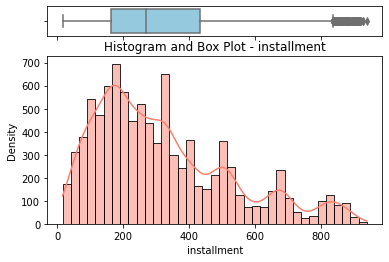

Skewness: 0.9123795470488175
Right Skewed 

Kurtosis: 0.13720938669419702
Platykurtic 

JB Test for Normality
1336.3593424289259 0.0
Distribution is not normal 


Histogram and Box Plot - revol.util


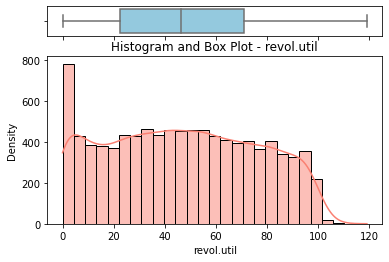

Skewness: 0.05997604792027563
Right Skewed 

Kurtosis: -1.1165106228040504
Platykurtic 

JB Test for Normality
503.2378880158785 0.0
Distribution is not normal 


Histogram and Box Plot - revol.bal


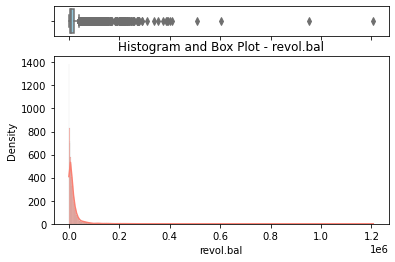

Skewness: 11.15931049753884
Right Skewed 

Kurtosis: 259.51904874872037
Leptokurtic 

JB Test for Normality
27077108.766577367 0.0
Distribution is not normal 


Histogram and Box Plot - days.with.cr.line


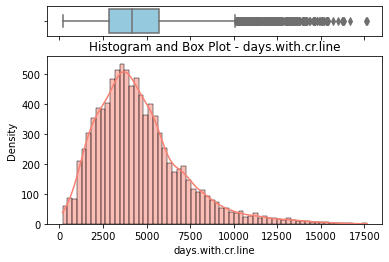

Skewness: 1.1555672187692227
Right Skewed 

Kurtosis: 1.936222751108466
Platykurtic 

JB Test for Normality
3627.787596261711 0.0
Distribution is not normal 


Histogram and Box Plot - dti


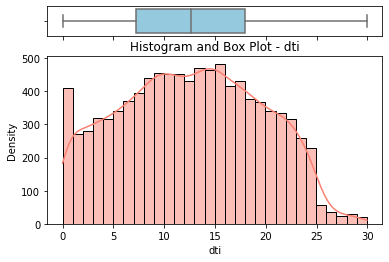

Skewness: 0.02393727340906256
Right Skewed 

Kurtosis: -0.9005117883560003
Platykurtic 

JB Test for Normality
324.5399356150307 0.0
Distribution is not normal 



In [11]:
# Box Plot & Histogram of Top 5 Important Numerical Features
master(df)

#### EDA Interpretation:

##### Class Imbalance:
There exists a class imbalance where the fully paid class (1) significantly outweighs the not fully paid class (0). In this case, the dataset is skewed towards the fully paid class. This could lead to models that are better at predicting the majority class but perform poorly on the minority class (not fully paid) which in reality also hold significant importance.

---------------------------------------------------------------------------------------------------------------------------
The pipeline uses random forest to identify top 5 most important numerical features based on its feature importance

##### installment
It shows monthly installments owed by the borrower if the loan is funded.

    1. Data is right-skewed with a skewness of 0.912.
    2. It exhibits a platykurtic distribution with a kurtosis of 0.137.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.
    
##### revol.util
The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).

    1. Data is right-skewed with a skewness of 0.060.
    2. It exhibits a platykurtic distribution with a kurtosis of -1.117.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.
    
##### revol.bal
The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle)

    1. Data is highly right-skewed with a skewness of 11.159.
    2. It exhibits a highly leptokurtic distribution with a kurtosis of 259.519.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.
    
##### days.with.cr.line
It indicates the number of days the borrower has had a credit line.

    1. Data is right-skewed with a skewness of 1.156.
    2. It exhibits a platykurtic distribution with a kurtosis of 1.936.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

##### dti
It shows debt-to-income ratio of the borrower (amount of debt divided by annual income).

    1. Data is right-skewed with a skewness of 0.024.
    2. It exhibits a platykurtic distribution with a kurtosis of -0.901.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 6

This function assumes that first 2 components explain significant variability in the dataset.
It then uses PCA to visualize patterns associated with class labels in a 2D plot:


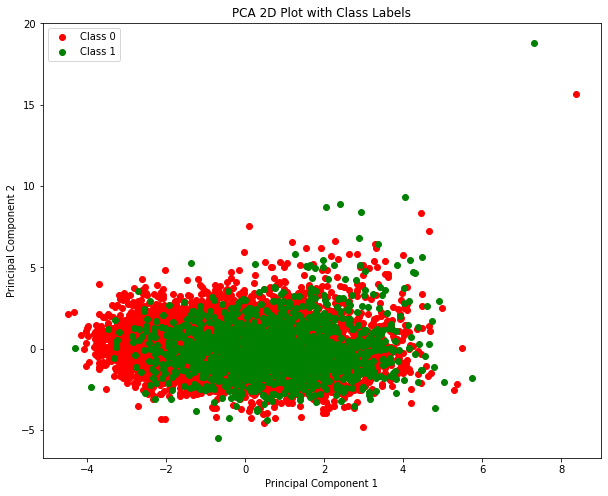

In [12]:
# Visualizing Decision Boundary Through PCA
master(df)

#### Comment:
Using the first two principal components we can visualize that there doesn't exists a linear decision boundary and a non-linear approach would be more appropriate for this dataset. Also, we can conclude that there doesn't exists a distinct decision boundary that can separate and classify whether the individual paid in full or not as both classes seem to overlap so we can create this hypothesis that the classifiers in our project might not give extremely good accuracy and roc score due to high complexity in the dataset and a further complex model might be needed like ANN or Ensemble.

In [13]:
# Data Transformation
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 7

1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 1




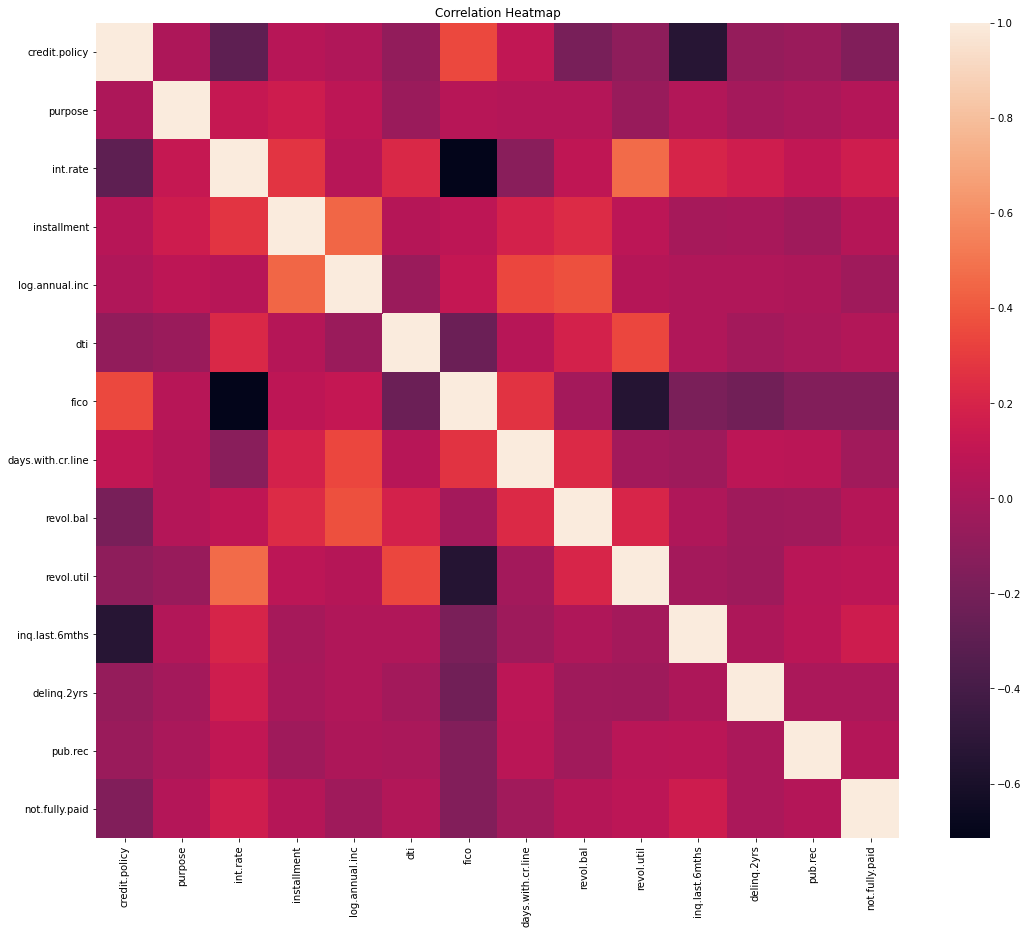


Mutual Information & Correlation of Each Feature with Target Feature
                   Mutual_Information  Correlation  Variance
int.rate                     0.014243     0.159560  0.999993
inq.last.6mths               0.014039     0.149502  1.001694
fico                         0.008725     0.149619  0.999732
days.with.cr.line            0.008286     0.029232  1.000259
revol.bal                    0.007786     0.053671  1.000086
credit.policy                0.007419     0.158119  0.997075
log.annual.inc               0.005387     0.033374  0.999620
purpose                      0.001970     0.047950  0.997337
delinq.2yrs                  0.001036     0.008877  0.999338
installment                  0.000946     0.049949  1.000148
revol.util                   0.000283     0.082105  0.999821
pub.rec                      0.000000     0.048655  1.002095
dti                          0.000000     0.037432  1.000044 

Type features as: 'Feature_name1,Feature_name2,Feature_name3...' 

What fe

In [14]:
# Filter Based Feature Selection
df_filter=master(df)

#### Comment:
We have selected the features that have the most mutual information and correlation with the Target Feature. Mutual information is a measure of dependence between two variables - gauges how much a feature contributes to the prediction of the target variable.For mutual information we’ve determined that the mutual information less than 0.001 translates to weak connection of a feature with target feature. Correlation explains the extent to which two features are linearly related. For our selection we've first prioritized mutual information ranking and second priority is given to correlation score because not having significant linear relationship doesn't necessarily translate to insignificant relationship. We’ve first selected features based on mutual information (from int.rate to delinq.2yrs). Most of these features (but not all) have a good correlation as well (relative to overall correlation scores).

In [15]:
# Wrapper (Recursive) Feature Selection
df_rfs=master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 2

How many features to select? 9

Following are the 9 features selected based on the given feature selector:

Index(['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
       'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths'],
      dtype='object')


#### Comment:
Number of feature parameter is used as a stopping criteria. Model Improvement Tolerance level would be a more accurate stopping criteria but not possible to do it through automated pipeline as there's no universal tolerance criteria as it varies for each dataset. Here number of features are set equal to filter selection number above for better comparison of different methods.

For Recursive Feature Selection we've used Random Forest Classifier with 100 trees (default). We've not used one of the models that we're using for this project in order to avoid any bias in the feature selection as feature selection through a particular model would obviously perform well for that model in comparison to other models. Besides, feature selection based on 100 trees would also render a more robust choice.

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 3


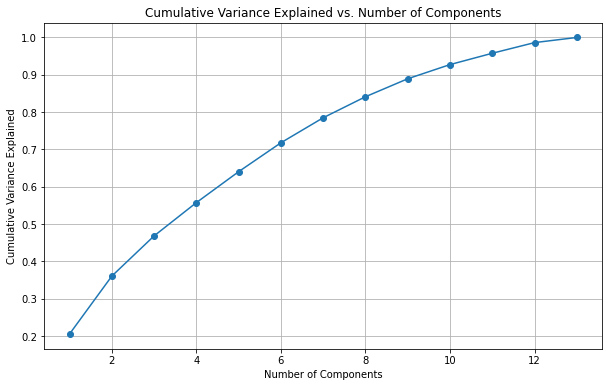


Enter the number of components for PCA: 9


In [16]:
# Feature Selection Through PCA
df_pca=master(df)

#### Comment:
Since first 9 components explain about 90% variability in the dataset, we've selected first 9 components as feature subset. Increasing the number of components increases cumulative variance but after 9 components, it does so very slightly. So increasing number of components any further would greatly increase model complexity but slightly increase the predictive power and it would be against the occam's razor principal.

In [17]:
# Comparison of Different Feature Selection Methods
res=master([df,df_filter,df_rfs,df_pca])
pd.DataFrame(res)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 4


,No FS,Filter FS,Recursive FS,PCA FS
KNN Classifier,0.814196,0.814196,0.814892,0.809325
Logistic Regression,0.832289,0.835073,0.834377,0.832289
Naive Bayes Classifier,0.771747,0.778010,0.812109,0.796103
Linear SVC,0.832985,0.832289,0.834377,0.834377
Decision Trees,0.728601,0.722338,0.736952,0.705637


#### Comment:
Selected Feature Subet: Recursive Feature Selection Subset

For comparison we've split the data into 3 sets (train/val/test:70/15/15) and train each model with each feature subset on the training data and computed accuracy of the model on the validation set. We've not used test set as it is supposed to be unseen data and using it for feature selection might cause data leakage and make model less generalizable eventually. 

Overall Feature Subset selected through Recursive Feature Selection gives the best accuracy for most of the models. So we'll continue our analysis using this feature subset.

In [18]:
# Data Splitting & CV Strategy
X_train,X_val,X_test,y_train,y_val,y_test,sk_folds=master(df_rfs)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10


#### Comment:
We've used 70% data for training and 15% each for validation and testing. Since our dataset has roughly 10000 rows, it's sufficient to test the model on only 15% of the data.

For Cross-Validation (CV), we've used used Stratified k-fold CV with 10 folds as our strategy since 10 folds is industry norm and stratification ensures that each fold preserves the same class distribution as the original dataset which is particularly important when dealing with imbalanced datasets like one we have.

In [19]:
# Initial Model Learning & Hyperparameters Tuning
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 10


{'KNN': {'n_neighbors': 13, 'p': 1},
 'Logistic Regression': {'C': 0.01, 'penalty': 'l2'},
 'Linear SVC': {'C': 0.0001, 'loss': 'squared_hinge'},
 'Decision Tree': {'max_depth': 7, 'min_samples_leaf': 2},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

#### Comment:
We've first trained the models on 70% of the dataset and tuned hyperparameters of the model on the 15% of data. Because our dataset has high class imbalance we've used auc score rather than accuracy score for evaluating the model on the validation set to pick the best hyperparameters. We've tested the following values of the hyperparameters:

##### knn_grid={'n_neighbors': [5, 7, 9, 11, 13], 'p': [1, 2, 3]}

We've tested number of neighbors to use for classification and whether distance metric used should be manhattan, euclidean, or minkowski with p=3.

##### lgr_grid={'C': [0.0001, 0.001, 0.01, 0.1], 'penalty': ['l1', 'l2']}

We've tested which penalty method to use to avoid overfitting by reducing impact of some features. L1-Lasso (some coefficients become exactly zero) or L2-Ridge (coefficient become closer to zero but not exactly). We've also tested C which determines the magnitude by which to penalize where smaller values of C result in stronger regularization, meaning the model will be penalized more for having large coefficients and therefore less overfit but we've to find right value of C so we don't underfit as well.

##### svc_grid={'C': [0.00001,0.0001, 0.001, 0.01], 'loss': ['hinge', 'squared_hinge']}

We've here tested different values of C which is again penalty term and smaller value of C means strong regularization. The higher the C, the more likely it'll fit closely to training data and won't allow misclassification with the margin. We've also tested different loss functions which are used to maximize margin.

##### dt_grid={'max_depth': [3, 7, 10, None], 'min_samples_leaf': [2, 5, 12]}

We've tested different levels of tree depth with lower depth meaning a tree that is more likely to generalize well whereas a deeper tree is more likely to learn data well but also prone to overfit so we've used validation set to find the correct depth. We've also tested different values of minimum samples required for a node to be considered for further splitting. A higher value can prevent the tree from splitting nodes that have few samples, potentially reducing overfitting.

Note: Naive Bayes Classifier has no hyperparameters to tune!

In [20]:
# Final Model Learning & Evaluation (Baseline Execution)
baseline=master(data=df_rfs,hyperparameters=hyperparameters,sk_folds=sk_folds)
baseline

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.840448,0.841036,0.839972,0.841472,0.851433
Precision (class 1),0.125000,0.222222,0.000000,0.208333,0.288288
Recall (class 0),0.994205,0.994205,0.995033,0.984272,0.934603
Recall (class 1),0.004367,0.008734,0.000000,0.021834,0.139738
F1-score (class 0),0.910884,0.911229,0.910951,0.907287,0.891081
F1-score (class 1),0.008439,0.016807,0.000000,0.039526,0.188235
Testing Accuracy,0.836465,0.837161,0.836465,0.830898,0.807933
Training Accuracy,0.842648,0.839577,0.840560,0.852844,0.818450
AUC,0.618256,0.661662,0.670479,0.612306,0.658181
Testing Accuracy CV,0.836292,0.839215,0.839528,0.830550,0.816558


#### Comment:
After finding the best hyperparameters we've again trained the model on 85% of the data (on both training and validation set combined) and finally evaluated it on 15% of the data. For fixed feature selection subset, cv strategy, and train-validation-test split we've done baseline execution on our imbalanced data for all algorithms and recorded all of the initially selected performance metrics.

Note: Results Interpretation is given at the end with comparison of baseline execution against class imbalance techniques.

## Class Imbalance Solutions Application

For consistency in comparison, we've kept the following fixed for each class imbalance solution approach as per our baseline execution:

#### Train/Validation/Test Split:
Train/Validation/Test split size is kept same as baseline execution in the ratio of 70:15:15. Same test set of the baseline execution is used for model evaluation of each class imbalance solution approach.
#### Feature Selection:
Best feature subset, which is the one that is selected through Recursive Feature Selection in the baseline execution, is also used here for each class imbalance solution approach. Following were the features selected through Recursive Feature Selection in the baseline execution:

Index(['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico','days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'not.fully.paid'], dtype='object')
#### CV Strategy:
CV Strategy of Stratified 10-fold Cross Validation employed in the baseline execution is also kept constant for each class imbalance solution approach.

Note: We've not fixed hyperparameters but retuned them because while maintaining consistency is important, it's also important that the comparison is fair and while previous hyperparameters were tuned to an imbalanced dataset, it's crucial to tune hyperparameters for a balanced set and then compare the results to isolate the impact of effectiveness of applied class imbalance solution technique.

In [21]:
# Data Preprocessing
df=master()
label_column="not.fully.paid"
master(df)
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 1

Please enter the source path: C:/Users/H-L-LAPTOP/loan_data.csv
Successfuly Connected to the Data Source
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final

In [22]:
# ADASYN Application
df_ADASYN=ADA(df)
master(df_ADASYN)
# df.to_csv("loan_data_ADASYN.csv",index=False)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 2


'Dataset is Already Clean!'

In [23]:
print(master(df_ADASYN),'\n')
print("Size After ADASYN Treatment")
print(df_ADASYN.shape,'\n')
print('Size Before Treatment')
print(df.shape)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3
0    51.150814
1    48.849186
Name: not.fully.paid, dtype: float64 

Size After ADASYN Treatment
(15728, 14) 

Size Before Treatment
(9578, 14)


In [24]:
# Retuning hyperparameters on balanced dataset (Keeping FS, Train-Validation-Test Split Same, & constant CV Strategy)
df_ADASYN=df_ADASYN[df_rfs.columns]
X_train,X_val,nouse1,y_train,y_val,nouse2,sk_folds=master(df_rfs)
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tu

{'KNN': {'n_neighbors': 13, 'p': 1},
 'Logistic Regression': {'C': 0.01, 'penalty': 'l2'},
 'Linear SVC': {'C': 0.0001, 'loss': 'squared_hinge'},
 'Decision Tree': {'max_depth': 7, 'min_samples_leaf': 2},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

In [25]:
adas=master(data=df_ADASYN,hyperparameters=hyperparameters,sk_folds=sk_folds,X_test=X_test,y_test=y_test,ci='Yes')
adas

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.961585,0.884259,0.892252,0.867295,0.882222
Precision (class 1),0.326159,0.225131,0.229133,0.275093,0.229050
Recall (class 0),0.663079,0.632450,0.610099,0.838576,0.657285
Recall (class 1),0.860262,0.563319,0.611354,0.323144,0.537118
F1-score (class 0),0.784909,0.737452,0.724680,0.852694,0.753321
F1-score (class 1),0.472989,0.321696,0.333333,0.297189,0.321149
Testing Accuracy,0.694502,0.621434,0.610299,0.756437,0.638135
Training Accuracy,0.794060,0.600763,0.599117,0.759126,0.591338
AUC,0.839153,0.659099,0.664392,0.648589,0.648410


In [26]:
# KMeansSMOTE Application
df_KSMO=KSMO(df)
master(df_KSMO)
# df.to_csv("loan_data_KMeansSMOTE.csv",index=False)

C:\Users\H-L-LAPTOP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 2


'Dataset is Already Clean!'

In [27]:
print(master(df_KSMO),'\n')
print("Size After KMeansSMOTE Treatment")
print(df_KSMO.shape,'\n')
print('Size Before Treatment')
print(df.shape)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3
1    50.009321
0    49.990679
Name: not.fully.paid, dtype: float64 

Size After KMeansSMOTE Treatment
(16093, 14) 

Size Before Treatment
(9578, 14)


In [28]:
# Retuning hyperparameters on balanced dataset (Keeping FS, Train-Validation-Test Split Same, & constant CV Strategy)
df_KSMO=df_KSMO[df_rfs.columns]
X_train,X_val,nouse1,y_train,y_val,nouse2,sk_folds=master(df_rfs)
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tu

{'KNN': {'n_neighbors': 13, 'p': 1},
 'Logistic Regression': {'C': 0.01, 'penalty': 'l2'},
 'Linear SVC': {'C': 0.0001, 'loss': 'squared_hinge'},
 'Decision Tree': {'max_depth': 7, 'min_samples_leaf': 2},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

In [29]:
smot=master(data=df_KSMO,hyperparameters=hyperparameters,sk_folds=sk_folds,X_test=X_test,y_test=y_test,ci='Yes')
smot

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.875000,0.877177,0.885657,0.870475,0.876171
Precision (class 1),0.326531,0.274566,0.261364,0.350515,0.231092
Recall (class 0),0.863411,0.792219,0.730960,0.895695,0.697020
Recall (class 1),0.349345,0.414847,0.502183,0.296943,0.480349
F1-score (class 0),0.869167,0.832536,0.800907,0.882905,0.776395
F1-score (class 1),0.337553,0.330435,0.343797,0.321513,0.312057
Testing Accuracy,0.781489,0.732081,0.694502,0.800278,0.662491
Training Accuracy,0.865414,0.801374,0.785949,0.867022,0.747715
AUC,0.739741,0.666380,0.668827,0.676165,0.637218


In [30]:
# Deep Learning Application
# Deep Learning Data Generator Source: app.mostly.ai
status_mapping={0:'No',1:'Yes'}
df[label_column]=df[label_column].map(status_mapping)
#df.to_csv("df_clean.csv",index=False)
df_DL=master()
master(df_DL)
status_mapping_reverse={'No':0,'Yes':1}
df_DL[label_column]=df_DL[label_column].map(status_mapping_reverse)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 1

Please enter the source path: C:/Users/H-L-LAPTOP/loan_data_DL.csv
Successfuly Connected to the Data Source
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Fi

In [31]:
print(master(df_DL),'\n')
print("Size After Deep Learning Data Generation Treatment")
print(df_DL.shape)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3
1    50.16531
0    49.83469
Name: not.fully.paid, dtype: float64 

Size After Deep Learning Data Generation Treatment
(15728, 14)


#### Comment:
Through Deep Learning Data Generators, we've generated synthetic data of same size as ADASYN dataset and balanced classes. Now the dataset has class imbalance ratio rougly 50:50.

Note: In this case, we're training a model on a completely synthetic data rather than oversampled data with some synthetic data points.

In [32]:
# Retuning hyperparameters on balanced dataset (Keeping FS, Train-Validation-Test Split Same, & constant CV Strategy)
df_DL=df_DL[df_rfs.columns]
X_train,X_val,nouse1,y_train,y_val,nouse2,sk_folds=master(df_DL)
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tu

{'KNN': {'n_neighbors': 13, 'p': 1},
 'Logistic Regression': {'C': 0.1, 'penalty': 'l1'},
 'Linear SVC': {'C': 0.001, 'loss': 'squared_hinge'},
 'Decision Tree': {'max_depth': 7, 'min_samples_leaf': 12},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

In [33]:
dl=master(data=df_DL,hyperparameters=hyperparameters,sk_folds=sk_folds,X_test=X_test,y_test=y_test,ci='Yes')
dl

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.881299,0.889640,0.887892,0.894509,0.879392
Precision (class 1),0.226103,0.238616,0.236697,0.209396,0.265625
Recall (class 0),0.651490,0.653974,0.655629,0.512417,0.766556
Recall (class 1),0.537118,0.572052,0.563319,0.681223,0.445415
F1-score (class 0),0.749167,0.753817,0.754286,0.651579,0.819107
F1-score (class 1),0.318241,0.336761,0.333333,0.320329,0.332790
Testing Accuracy,0.633264,0.640919,0.640919,0.539318,0.715379
Training Accuracy,0.655521,0.606822,0.605326,0.623279,0.600688
AUC,0.638276,0.663810,0.663224,0.636870,0.656952


#### Combined Results

In [34]:
print("Baseline")
print("-"*109)
print(tabulate(baseline,headers='keys',tablefmt='psql'),"\n\n")

print("CI Solution # 1: ADASYN")
print("-"*107)
print(tabulate(adas,headers='keys',tablefmt='psql'),"\n\n")

print("CI Solution # 2: KMeansSMOTE")
print("-"*107)
print(tabulate(smot,headers='keys',tablefmt='psql'),"\n\n")

print("CI Solution # 3: Deep Learning Generator")
print("-"*107)
print(tabulate(dl,headers='keys',tablefmt='psql'),"\n\n")

Baseline
-------------------------------------------------------------------------------------------------------------
+---------------------+------------+-----------------------+--------------+-----------------+---------------+
|                     |        KNN |   Logistic Regression |   Linear SVC |   Decision Tree |   Naive Bayes |
|---------------------+------------+-----------------------+--------------+-----------------+---------------|
| Precision (class 0) | 0.840448   |            0.841036   |     0.839972 |       0.841472  |      0.851433 |
| Precision (class 1) | 0.125      |            0.222222   |     0        |       0.208333  |      0.288288 |
| Recall (class 0)    | 0.994205   |            0.994205   |     0.995033 |       0.984272  |      0.934603 |
| Recall (class 1)    | 0.00436681 |            0.00873362 |     0        |       0.0218341 |      0.139738 |
| F1-score (class 0)  | 0.910884   |            0.911229   |     0.910951 |       0.907287  |      0.891081 |
|

#### Result Interpretation:

It has been observed for each CI solution, a drop in testing accuracy, which is to be expected in comparison to baseline as previously algorithms were biased and majorly predicting only major class and test set had mostly major class values so testing accuracy was going to be good, even if we don’t train a model and simply predict major class to all data points. However, it was not a good model as we can see from minority class (1) precision, recall, and f1-score and AUC score

------------------------------------------------------------------------------------------------------------------------------

#### Baseline Results:
1. The baseline models demonstrate significant class imbalance issues, especially in terms of precision, recall, and F1-score for the minority class (class 1).
2. Precision for class 1 is low across all models, indicating a high number of false positives in predicting the minority class.
3. Recall for class 1 is also low, indicating that the models are missing a large number of positive instances.
4. AUC scores are relatively low, indicating poor discriminative ability between the two classes.

#### CI Solution #1: ADASYN (Adaptive Synthetic Sampling)
1. ADASYN has improved the performance metrics for class 1 compared to the baseline.
2. Precision, recall, and F1-score for class 1 have increased, indicating better detection of positive instances.
3. However, there's still room for improvement as precision and recall for class 1 are relatively low.
4. AUC score is also slightly improved, indicating better overall discriminative ability, specially for KNN model.

#### CI Solution #2: KMeansSMOTE (K-Means Synthetic Minority Over-sampling Technique)
1. KMeansSMOTE has also shown improvements compared to the baseline, especially in terms of F-1 score and recall for class 1.
2. Precision for class 1 has increased, indicating fewer false positives.
3. Recall for class 1 has also increased, indicating better detection of positive instances.
4. AUC score has also slightly improved compared to the baseline for most models but in KNN it's significant.

#### CI Solution #3: Deep Learning Generator
1. This solution has shown mixed results compared to the other approaches.
   While recall for class 1 has improved in a similar drastic manner as shown in previous approach, precision has shown minuscule improvement and even decreased in Naive Bayes, indicating a better detection of positive instances and similar number of false negatives to baseline.
2. Overall, the performance metrics for class 1 are slightly better than the baseline but not as good as ADASYN and KMeansSMOTE
3. AUC score is comparable to ADASYN and KMeansSMOTE but slightly lower.

#### General Observations:
1. All class imbalance solutions have led to improvements in performance metrics compared to the baseline, especially in terms of precision, recall, F-1 score and AUC for class 1.
2. However, there's still room for further improvement, particularly in increasing AUC for class 1 for better distinction.
3. The choice between ADASYN, KMeansSMOTE, and deep learning-based approaches should consider the specific characteristics of the dataset available. for eg in above done PCA we can see non linear boundary data sets hence the ADASYN out performs All the CI and Baseline if we compare it with rest of the results specially in terms of AUC and Recall. specifically if you compare KNN model.
4. Also note that compared to rest of models KNN shows far better performance in AUC for ADASYN and KMeansSMOTE maybe due to the characterstics of data handling of these two CI method.

## Dataset 2
Title: Hotel Reservation Classification Dataset

Domain: Hospitality

Number of Rows: 36275

Number of Columns: 19

Feature Type: Mixed

Class Balance: 67:33 (Percentage)

Source: https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [74]:
# Loading the dataset
df=master()
label_column="booking_status"

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 1

Please enter the source path: C:/Users/H-L-LAPTOP/Hotel Reservations.csv
Successfuly Connected to the Data Source


In [75]:
# Manually looking at the data
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [77]:
# Manually Dropping Irrelevant Features
df.drop(['Booking_ID'],axis=1,inplace=True)

In [78]:
# Manually target variable labelling
status_mapping={'Not_Canceled':0,'Canceled':1}
df['booking_status']=df['booking_status'].map(status_mapping)
df=df.rename(columns={'booking_status':'booking_canceled'})
label_column='booking_canceled'

In [79]:
# Data Cleaning
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 2
Dataset is treated for duplicated values successfully


In [80]:
# Class Imbalance
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3


0    71.376923
1    28.623077
Name: booking_canceled, dtype: float64

#### Comment:
There's high class imbalance found in the target variable with only 28% percent those cases where the reservation was cancelled due to cancellations or no-shows. This distribution of the target variable is expected as mostly reservations are up held but sometimes cancelled. However, it's still very important to predict reservation that are likely to be cancelled (however small in number) to make sure hotel operations are run smoothly.

In [84]:
# Numerical Summary
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 4


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_canceled
count,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000
mean,1.890000,0.141231,0.882385,2.261923,0.042115,66.452846,2017.850269,7.332923,15.750231,0.032769,0.028538,0.213115,105.695838,0.741962,0.286231
std,0.528702,0.462502,0.887371,1.512341,0.200856,68.606799,0.356814,3.138925,8.849394,0.178035,0.408891,2.068243,37.876592,0.815109,0.452007
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,12.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.750000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,44.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,100.000000,1.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,100.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,127.000000,1.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 5

Histogram and Box Plot - lead_time


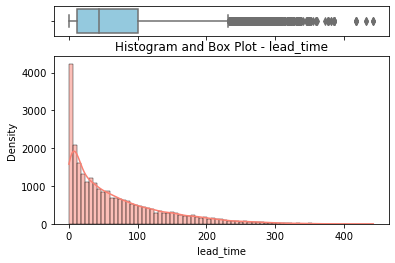

Skewness: 1.407775352031065
Right Skewed 

Kurtosis: 1.8721539542153334
Platykurtic 

JB Test for Normality
12384.976711714591 0.0
Distribution is not normal 


Histogram and Box Plot - avg_price_per_room


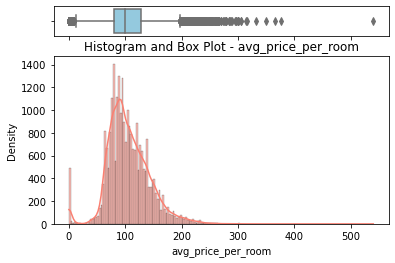

Skewness: 0.5883791721800679
Right Skewed 

Kurtosis: 2.6098295830860536
Platykurtic 

JB Test for Normality
8878.968208253349 0.0
Distribution is not normal 


Histogram and Box Plot - arrival_date


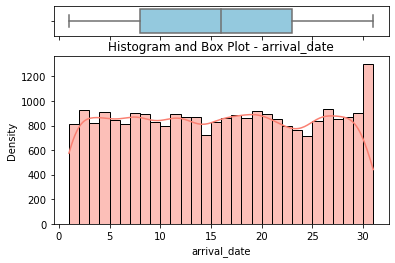

Skewness: 0.012175906132715348
Right Skewed 

Kurtosis: -1.204376314668733
Platykurtic 

JB Test for Normality
1572.0415946036203 0.0
Distribution is not normal 


Histogram and Box Plot - no_of_special_requests


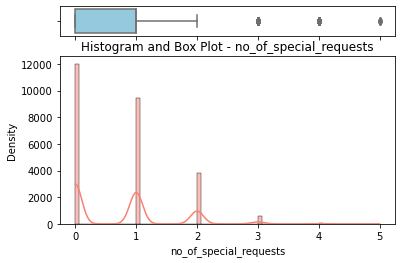

Skewness: 0.9110681861798929
Right Skewed 

Kurtosis: 0.4102234417420427
Platykurtic 

JB Test for Normality
3779.169584267096 0.0
Distribution is not normal 


Histogram and Box Plot - arrival_month


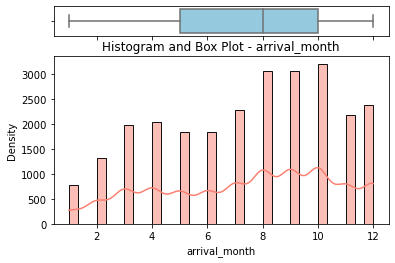

Skewness: -0.2922206825085373
Left Skewed 

Kurtosis: -1.0039771473342551
Platykurtic 

JB Test for Normality
1462.0036399718208 0.0
Distribution is not normal 



In [85]:
# Box Plot & Histogram of Top 5 Important Numerical Features
master(df)

#### EDA Interpretation:

##### Class Imbalance:
There exists a class imbalance where the fully paid class (1) significantly outweighs the not fully paid class (0). In this case, the dataset is skewed towards the fully paid class. This could lead to models that are better at predicting the majority class but perform poorly on the minority class (not fully paid) which in reality also hold significant importance.

---------------------------------------------------------------------------------------------------------------------------
The pipeline uses random forest to identify top 5 most important numerical features based on its feature importance

##### lead_time
It shows number of days between the date of booking and the arrival date.

    1. Data is right-skewed with a skewness of 1.408.
    2. It exhibits a platykurtic distribution with a kurtosis of 1.872.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

    
##### avg_price_per_room
Average price per day of the reservation; prices of the rooms are dynamic. (in euros)

    1. Data is right-skewed with a skewness of 0.588.
    2. It exhibits a platykurtic distribution with a kurtosis of 2.610.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.
    
##### arrival_date
It indicates Date of the month

    1. Data is right-skewed with a skewness of 0.012.
    2. It exhibits a highly leptokurtic distribution with a kurtosis of -1.204.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.
    
##### no_of_special_requests
It indicates total number of special requests made by the customer (e.g. high floor, view from the room, etc)

    1. Data is highly right-skewed with a skewness of 0.911.
    2. It exhibits a highly leptokurtic distribution with a kurtosis of 0.410. 
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

##### arrival_month
It shows month of arrival date

    1. Data is left-skewed with a skewness of -0.292.
    2. It exhibits a platykurtic distribution with a kurtosis of -1.004.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 6

This function assumes that first 2 components explain significant variability in the dataset.
It then uses PCA to visualize patterns associated with class labels in a 2D plot:


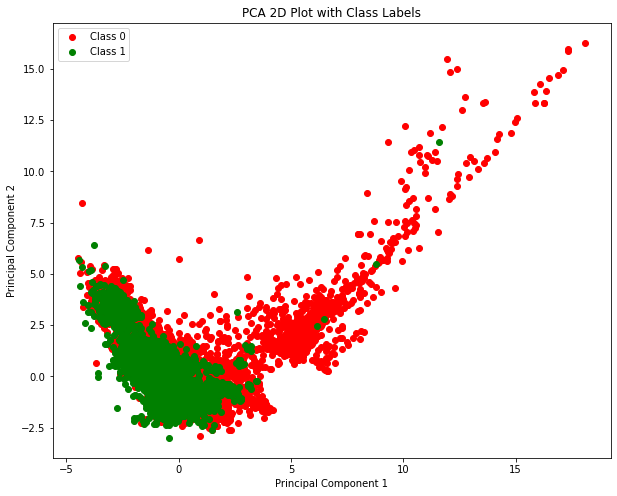

In [86]:
# Visualizing Decision Boundary Through PCA
master(df)

#### Comment:
Using the first two principal components we can visualize that there exists a linear decision boundary and so a linear approach would be more appropriate for this dataset. Also, we can conclude that there exists a distinct decision boundary that can separate and classify whether the booking reservation will be cancelled or not as both classes seem to overlap for some part but mostly we can visualize both classes separately so we can create this hypothesis that the classifiers in our project might give good accuracy and roc score due to low complexity in the dataset and a simpler model would do a better performance and a complex model won't be needed.

In [87]:
# Data Transformation
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 7

1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 1




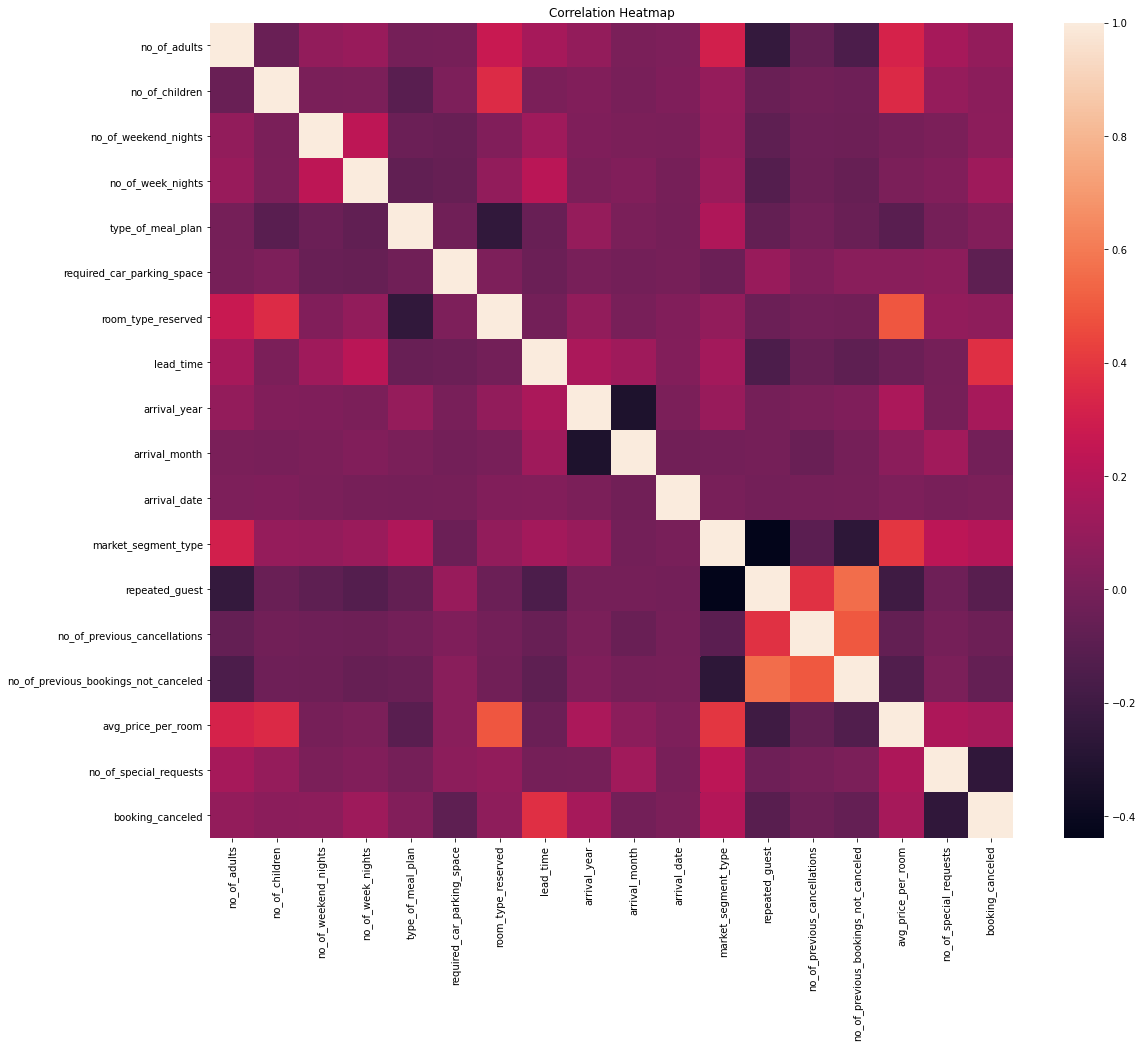


Mutual Information & Correlation of Each Feature with Target Feature
                                      Mutual_Information  Correlation  \
lead_time                                       0.080631     0.371450   
avg_price_per_room                              0.044823     0.155853   
no_of_special_requests                          0.040907     0.257750   
market_segment_type                             0.034237     0.197387   
arrival_month                                   0.016649     0.012817   
arrival_year                                    0.014816     0.152222   
no_of_previous_bookings_not_canceled            0.013564     0.064256   
repeated_guest                                  0.010723     0.112258   
no_of_week_nights                               0.007130     0.126910   
no_of_adults                                    0.007053     0.093289   
required_car_parking_space                      0.005277     0.087028   
type_of_meal_plan                               0.0049

In [88]:
# Filter Based Feature Selection
df_filter=master(df)

#### Comment:
We have selected the features that have the most mutual information and correlation with the Target Feature. Mutual information is a measure of dependence between two variables - gauges how much a feature contributes to the prediction of the target variable.For mutual information we’ve determined that the mutual information less than 0.005 translates to weak connection of a feature with target feature. Correlation explains the extent to which two features are linearly related. For our selection we've first prioritized mutual information ranking and second priority is given to correlation score because not having significant linear relationship doesn't necessarily translate to insignificant relationship.
Based on our threshold we’ve selected features based on mutual information (from lead_time to required_car_parking_space). Most of these features (but not all) have a good correlation as well (relative to overall correlation scores).

In [89]:
# Wrapper (Recursive) Feature Selection
df_rfs=master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 2

How many features to select? 11

Following are the 11 features selected based on the given feature selector:

Index(['no_of_adults', 'no_of_weekend_nights', 'no_of_week_nights',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'avg_price_per_room',
       'no_of_special_requests'],
      dtype='object')


#### Comment:
Number of feature parameter is used as a stopping criteria. Model Improvement Tolerance level would be a more accurate stopping criteria but not possible to do it through automated pipeline as there's no universal tolerance criteria as it varies for each dataset. Here number of features are set equal to filter selection number above for better comparison of different methods.

For Recursive Feature Selection we've used Random Forest Classifier with 100 trees (default). We've not used one of the models that we're using for this project in order to avoid any bias in the feature selection as feature selection through a particular model would obviously perform well for that model in comparison to other models. Besides, feature selection based on 100 trees would also render a more robust choice.

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 3


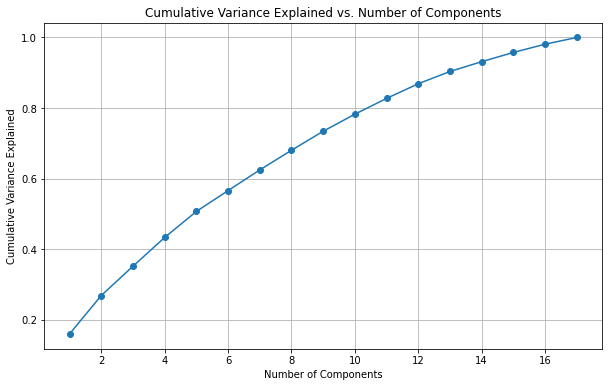


Enter the number of components for PCA: 13


In [90]:
# Feature Selection Through PCA
df_pca=master(df)

#### Comment:
Since first 13 components explain about 90% variability in the dataset, we've selected first 13 components as feature subset. Increasing the number of components increases cumulative variance but after 9 components, it does so very slightly. So increasing number of components any further would greatly increase model complexity but slightly increase the predictive power and it would be against the occam's razor principal.

In [91]:
# Comparison of Different Feature Selection Methods
res=master([df,df_filter,df_rfs,df_pca])
pd.DataFrame(res)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 4


,No FS,Filter FS,Recursive FS,PCA FS
KNN Classifier,0.819277,0.817483,0.817739,0.808511
Logistic Regression,0.804922,0.806716,0.806204,0.800820
Naive Bayes Classifier,0.434248,0.481415,0.769546,0.750577
Linear SVC,0.802871,0.801846,0.800564,0.796975
Decision Trees,0.802615,0.796206,0.808254,0.759549


#### Comment:
Selected Feature Subet: Recursive Feature Selection Subset

For comparison we've split the data into 3 sets (train/val/test:70/15/15) and train each model with each feature subset on the training data and computed accuracy of the model on the validation set. We've not used test set as it is supposed to be unseen data and using it for feature selection might cause data leakage and make model less generalizable eventually. 

Overall Feature Subset selected through Recursive Feature Selection gives the best accuracy for most of the models. So we'll continue our analysis using this feature subset. Recursive FS perform best on Decision Trees & Naive Bayes whereas it performs well on Linear SVC, Logistic Regression, & KNN. No FS & Filter FS can't be considered as results are very bad on Naive Bayes & PCA FS has bad results than Recursive FS overall.

In [92]:
# Data Splitting & CV Strategy
X_train,X_val,X_test,y_train,y_val,y_test,sk_folds=master(df_rfs)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10


#### Comment:
We've used 70% data for training and 15% each for validation and testing. Since our dataset has 260000 rows, it's sufficient to test the model on only 15% of the data.

For Cross-Validation (CV), we've used used Stratified k-fold CV with 10 folds as our strategy since 10 folds is industry norm and stratification ensures that each fold preserves the same class distribution as the original dataset which is particularly important when dealing with imbalanced datasets like one we have.

In [93]:
# Initial Model Learning & Hyperparameters Tuning
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 10


{'KNN': {'n_neighbors': 13, 'p': 1},
 'Logistic Regression': {'C': 0.1, 'penalty': 'l1'},
 'Linear SVC': {'C': 0.01, 'loss': 'hinge'},
 'Decision Tree': {'max_depth': 10, 'min_samples_leaf': 12},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

#### Comment:
We've first trained the models on 70% of the dataset and tuned hyperparameters of the model on the 15% of data. Because our dataset has high class imbalance we've used auc score rather than accuracy score for evaluating the model on the validation set to pick the best hyperparameters. We've tested the following values of the hyperparameters:

##### knn_grid={'n_neighbors': [5, 7, 9, 11, 13], 'p': [1, 2, 3]}

We've tested number of neighbors to use for classification and whether distance metric used should be manhattan, euclidean, or minkowski with p=3.

##### lgr_grid={'C': [0.0001, 0.001, 0.01, 0.1], 'penalty': ['l1', 'l2']}

We've tested which penalty method to use to avoid overfitting by reducing impact of some features. L1-Lasso (some coefficients become exactly zero) or L2-Ridge (coefficient become closer to zero but not exactly). We've also tested C which determines the magnitude by which to penalize where smaller values of C result in stronger regularization, meaning the model will be penalized more for having large coefficients and therefore less overfit but we've to find right value of C so we don't underfit as well.

##### svc_grid={'C': [0.00001,0.0001, 0.001, 0.01], 'loss': ['hinge', 'squared_hinge']}

We've here tested different values of C which is again penalty term and smaller value of C means strong regularization. The higher the C, the more likely it'll fit closely to training data and won't allow misclassification with the margin. We've also tested different loss functions which are used to maximize margin.

##### dt_grid={'max_depth': [3, 7, 10, None], 'min_samples_leaf': [2, 5, 12]}

We've tested different levels of tree depth with lower depth meaning a tree that is more likely to generalize well whereas a deeper tree is more likely to learn data well but also prone to overfit so we've used validation set to find the correct depth. We've also tested different values of minimum samples required for a node to be considered for further splitting. A higher value can prevent the tree from splitting nodes that have few samples, potentially reducing overfitting.

Note: Naive Bayes Classifier has no hyperparameters to tune!

In [94]:
# Final Model Learning & Evaluation (Baseline Execution)
hyperparameters['Linear SVC']['C']=0.001 # Model failed to converge on C=0.01 when trained on train & validation set
baseline=master(data=df_rfs,hyperparameters=hyperparameters,sk_folds=sk_folds)
baseline

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.853180,0.833005,0.806762,0.881018,0.852137
Precision (class 1),0.721398,0.707459,0.727811,0.775202,0.561013
Recall (class 0),0.905566,0.909874,0.933932,0.919928,0.794614
Recall (class 1),0.610762,0.544395,0.441256,0.689686,0.655605
F1-score (class 0),0.878593,0.869744,0.865701,0.900053,0.822371
F1-score (class 1),0.661486,0.615307,0.549414,0.729948,0.604632
Testing Accuracy,0.821282,0.805385,0.793077,0.854103,0.754872
Training Accuracy,0.852262,0.807783,0.797557,0.860000,0.766199
AUC,0.867397,0.844601,0.839123,0.893469,0.796077
Testing Accuracy CV,0.831038,0.807885,0.796846,0.847885,0.767308


#### Comment:
After finding the best hyperparameters we've again trained the model on 85% of the data (on both training and validation set combined) and finally evaluated it on 15% of the data. For fixed feature selection subset, cv strategy, and train-validation-test split we've done baseline execution on our imbalanced data for all algorithms and recorded all of the initially selected performance metrics.

Note: Results Interpretation is given at the end with comparison of baseline execution against class imbalance techniques.

## Class Imbalance Solutions Application

For consistency in comparison, we've kept the following fixed for each class imbalance solution approach as per our baseline execution:

#### Train/Validation/Test Split:
Train/Validation/Test split size is kept same as baseline execution in the ratio of 70:15:15. Same test set of the baseline execution is used for model evaluation of each class imbalance solution approach.
#### Feature Selection:
Best feature subset, which is the one that is selected through Recursive Feature Selection in the baseline execution, is also used here for each class imbalance solution approach. Following were the features selected through Recursive Feature Selection in the baseline execution:

Index(['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico','days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'not.fully.paid'], dtype='object')
#### CV Strategy:
CV Strategy of Stratified 10-fold Cross Validation employed in the baseline execution is also kept constant for each class imbalance solution approach.

Note: We've not fixed hyperparameters but retuned them because while maintaining consistency is important, it's also important that the comparison is fair and while previous hyperparameters were tuned to an imbalanced dataset, it's crucial to tune hyperparameters for a balanced set and then compare the results to isolate the impact of effectiveness of applied class imbalance solution technique.

In [95]:
# Data Preprocessing
df=master()
label_column="booking_status"
# Manually Dropping Irrelevant Features
df.drop(['Booking_ID'],axis=1,inplace=True)
# Manually target variable labelling
status_mapping={'Not_Canceled':0,'Canceled':1}
df['booking_status']=df['booking_status'].map(status_mapping)
df=df.rename(columns={'booking_status':'booking_canceled'})
label_column='booking_canceled'
master(df)
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 1

Please enter the source path: C:/Users/H-L-LAPTOP/Hotel Reservations.csv
Successfuly Connected to the Data Source
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning


In [96]:
## ADASYN Application
df_ADASYN=ADA(df)
master(df_ADASYN)
# df.to_csv("Hotel Reservations_ADASYN.csv",index=False)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 2
Dataset is treated for duplicated values successfully


In [97]:
print(master(df_ADASYN),'\n')
print("Size After ADASYN Treatment")
print(df_ADASYN.shape,'\n')
print('Size Before Treatment')
print(df.shape)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3
0    50.428164
1    49.571836
Name: booking_canceled, dtype: float64 

Size After ADASYN Treatment
(36785, 18) 

Size Before Treatment
(26000, 18)


In [98]:
# Retuning hyperparameters on balanced dataset (Keeping FS, Train-Validation-Test Split Same, & constant CV Strategy)
df_ADASYN=df_ADASYN[df_rfs.columns]
X_train,X_val,nouse1,y_train,y_val,nouse2,sk_folds=master(df_rfs)
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tu

{'KNN': {'n_neighbors': 13, 'p': 1},
 'Logistic Regression': {'C': 0.1, 'penalty': 'l1'},
 'Linear SVC': {'C': 0.01, 'loss': 'hinge'},
 'Decision Tree': {'max_depth': 10, 'min_samples_leaf': 12},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

In [101]:
hyperparameters['Linear SVC']['C']=0.001 # SVM fails to converge otherwise
adas=master(data=df_ADASYN,hyperparameters=hyperparameters,sk_folds=sk_folds,X_test=X_test,y_test=y_test,ci='Yes')
adas

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.958829,0.909132,0.911561,0.924211,0.913483
Precision (class 1),0.598016,0.544425,0.533835,0.637423,0.453302
Recall (class 0),0.752603,0.725673,0.710592,0.810054,0.583842
Recall (class 1),0.919283,0.818834,0.827803,0.834081,0.861883
F1-score (class 0),0.843291,0.807109,0.798628,0.863375,0.712377
F1-score (class 1),0.724638,0.654011,0.649086,0.722611,0.594127
Testing Accuracy,0.800256,0.752308,0.744103,0.816923,0.663333
Training Accuracy,0.841814,0.724342,0.726389,0.814949,0.704961
AUC,0.923929,0.844384,0.843981,0.911505,0.801532


In [102]:
## KMeansSMOTE Application
df_KSMO=KSMO(df)
master(df_KSMO)
# df.to_csv("Hotel Reservations_KMeansSMOTE.csv",index=False)

C:\Users\H-L-LAPTOP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 2
Dataset is treated for duplicated values successfully


In [103]:
print(master(df_KSMO),'\n')
print("Size After KMeansSMOTE Treatment")
print(df_KSMO.shape,'\n')
print('Size Before Treatment')
print(df.shape)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3
1    50.016167
0    49.983833
Name: booking_canceled, dtype: float64 

Size After KMeansSMOTE Treatment
(37112, 18) 

Size Before Treatment
(26000, 18)


In [104]:
# Retuning hyperparameters on balanced dataset (Keeping FS, Train-Validation-Test Split Same, & constant CV Strategy)
df_KSMO=df_KSMO[df_rfs.columns]
X_train,X_val,nouse1,y_train,y_val,nouse2,sk_folds=master(df_rfs)
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tu

{'KNN': {'n_neighbors': 13, 'p': 1},
 'Logistic Regression': {'C': 0.1, 'penalty': 'l1'},
 'Linear SVC': {'C': 0.01, 'loss': 'hinge'},
 'Decision Tree': {'max_depth': 10, 'min_samples_leaf': 12},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

In [105]:
hyperparameters['Linear SVC']['C']=0.001 # SVM fails to converge otherwise
smot=master(data=df_KSMO,hyperparameters=hyperparameters,sk_folds=sk_folds,X_test=X_test,y_test=y_test,ci='Yes')
smot

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.887695,0.864137,0.852874,0.906038,0.862394
Precision (class 1),0.675541,0.598419,0.578025,0.692800,0.444091
Recall (class 0),0.859964,0.817594,0.809695,0.862118,0.623339
Recall (class 1),0.728251,0.678924,0.651121,0.776682,0.751570
F1-score (class 0),0.873609,0.840221,0.830724,0.883533,0.723635
F1-score (class 1),0.700906,0.636134,0.612400,0.732347,0.558294
Testing Accuracy,0.822308,0.777949,0.764359,0.837692,0.660000
Training Accuracy,0.877794,0.825329,0.821905,0.875479,0.765700
AUC,0.891416,0.829477,0.817629,0.907062,0.752011


In [106]:
# Deep Learning Application
# Deep Learning Data Generator Source: app.mostly.ai
status_mapping={0:'No',1:'Yes'}
df[label_column]=df[label_column].map(status_mapping)
#df.to_csv("df_clean.csv",index=False)
df_DL=master()
master(df_DL)
status_mapping_reverse={'No':0,'Yes':1}
df_DL[label_column]=df_DL[label_column].map(status_mapping_reverse)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 1

Please enter the source path: C:/Users/H-L-LAPTOP/Hotel Reservations_DL.csv
Successfuly Connected to the Data Source
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunni

In [107]:
print(master(df_DL),'\n')
print("Class Size After Deep Learning Data Generation Treatment")
print(df_DL.shape)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3
0    50.279929
1    49.720071
Name: booking_canceled, dtype: float64 

Class Size After Deep Learning Data Generation Treatment
(38224, 18)


#### Comment:
Through Deep Learning Data Generators, we've generated synthetic data of same size as ADASYN dataset and balanced classes. Now the dataset has class imbalance ratio rougly 50:50.

Note: In this case, we're training a model on a completely synthetic data rather than oversampled data with some synthetic data points.

In [108]:
# Retuning hyperparameters on balanced dataset (Keeping FS, Train-Validation-Test Split Same, & constant CV Strategy)
df_DL=df_DL[df_rfs.columns]
X_train,X_val,nouse1,y_train,y_val,nouse2,sk_folds=master(df_DL)
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tu

{'KNN': {'n_neighbors': 13, 'p': 1},
 'Logistic Regression': {'C': 0.1, 'penalty': 'l1'},
 'Linear SVC': {'C': 0.01, 'loss': 'hinge'},
 'Decision Tree': {'max_depth': 7, 'min_samples_leaf': 12},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

In [109]:
hyperparameters['Linear SVC']['C']=0.001 # SVM fails to converge otherwise
dl=master(data=df_DL,hyperparameters=hyperparameters,sk_folds=sk_folds,X_test=X_test,y_test=y_test,ci='Yes')
dl

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.906678,0.908479,0.908025,0.892685,0.910256
Precision (class 1),0.551556,0.545183,0.541617,0.600567,0.466963
Recall (class 0),0.736086,0.727110,0.723160,0.797487,0.611849
Recall (class 1),0.810762,0.817040,0.817040,0.760538,0.849327
F1-score (class 0),0.812525,0.807738,0.805117,0.842405,0.731802
F1-score (class 1),0.656500,0.653984,0.651412,0.671152,0.602609
Testing Accuracy,0.757436,0.752821,0.750000,0.786923,0.679744
Training Accuracy,0.778824,0.746291,0.744475,0.767775,0.722930
AUC,0.843829,0.842516,0.842283,0.853208,0.798170


#### Combined Results

In [110]:
print("Baseline")
print("-"*109)
print(tabulate(baseline,headers='keys',tablefmt='psql'),"\n\n")

print("CI Solution # 1: ADASYN")
print("-"*107)
print(tabulate(adas,headers='keys',tablefmt='psql'),"\n\n")

print("CI Solution # 2: KMeansSMOTE")
print("-"*107)
print(tabulate(smot,headers='keys',tablefmt='psql'),"\n\n")

print("CI Solution # 3: Deep Learning Generator")
print("-"*107)
print(tabulate(dl,headers='keys',tablefmt='psql'),"\n\n")

Baseline
-------------------------------------------------------------------------------------------------------------
+---------------------+----------+-----------------------+--------------+-----------------+---------------+
|                     |      KNN |   Logistic Regression |   Linear SVC |   Decision Tree |   Naive Bayes |
|---------------------+----------+-----------------------+--------------+-----------------+---------------|
| Precision (class 0) | 0.85318  |              0.833005 |     0.806762 |        0.881018 |      0.852137 |
| Precision (class 1) | 0.721398 |              0.707459 |     0.727811 |        0.775202 |      0.561013 |
| Recall (class 0)    | 0.905566 |              0.909874 |     0.933932 |        0.919928 |      0.794614 |
| Recall (class 1)    | 0.610762 |              0.544395 |     0.441256 |        0.689686 |      0.655605 |
| F1-score (class 0)  | 0.878593 |              0.869744 |     0.865701 |        0.900053 |      0.822371 |
| F1-score (class

#### Result Interpretation:




#### Baseline Results:

Baseline models generally exhibit decent performance.

1. Precision (class 0): The precision for the majority class is relatively high across all models, indicating a low false positive rate.
2. Precision (class 1): Precision for the minority class varies but generally lower, suggesting a higher false positive rate for predicting the minority class.
3. Recall (class 0): Recall for the majority class is high, indicating a low false negative rate.
4. Recall (class 1): Recall for the minority class is generally lower, indicating a higher false negative rate.
5. Recall for class 0 is consistently higher than for class 1 across all models.
6. F1-scores for class 0 are notably higher compared to class 1, indicating better overall performance for the majority class.

#### CI Solution #1: ADASYN:
1. Precision for class 1 has generally decreased compared to the baseline for most models. This indicates that while ADASYN may have improved the model's ability to capture more instances of the minority class, it has also increased the number of false positives, which negatively impacts precision.
2. Precision (class 0): Precision for the previous majority class is high, indicating a low false positive rate.
3. Recall for class 1 has generally improved, suggesting better identification of positive cases after applying ADASYN.
4. F1-scores for class 1 have shown improvement in some models but might have dropped slightly in others.
5. Testing Accuracy: Overall accuracy has slightly decreased compared to the baseline, which is ok as in previously imbalance data set due to high bias towards majority class testing accuracy was higher
6. AUC: AUC values show improvement compared to the baseline for some models but not all. Specifically, the AUC has increased in two out of the five models (KNN and Decision Tree) after applying ADASYN. This suggests that ADASYN has effectively improved the discriminative ability of these models, leading to better overall performance in terms of AUC.

#### CI Solution #2: KMeansSMOTE:
1. Precision (class 0): Precision for the class 0 is high.
2. Precision (class 1): Precision for the class 1 is higher compared to ADASYN across all model besides naive bayes but precision for class 1 has also generally decreased compared to the baseline for most models after applying KMeansSMOTE. Similar to ADASYN, this suggests that while KMeansSMOTE may have effectively balanced the class distribution, it has also led to more false positive predictions for the minority class.
3. Recall for class 1 has generally improved, suggesting better identification of positive cases after applying KMeansSMOTE.
5. F1-scores for class 1 have shown improvement in some models but might have dropped slightly in others.
6. Testing Accuracy: Overall accuracy is comparable to ADASYN.
7. AUC: AUC values also show improvement compared to the baseline for some models but not all. Similar to ADASYN, the AUC has increased in two out of the five models (KNN and Decision Tree) after applying KMeansSMOTE. This indicates that KMeansSMOTE has effectively enhanced the discriminative ability of these models, resulting in better overall performance in terms of AUC.


#### CI Solution #3: Deep Learning Generator:
1. Precision (class 0): Precision for the majority class is high.
2. Precision for class 1 has also generally decreased compared to the baseline for most models after applying Deep Learning Generator. Similar to ADASYN & KMeansSMOTE this suggests that while Deep Learning Generator may have effectively balanced the class distribution, it has also led to more false positive predictions for the minority class.
3. Recall for class 1 has generally improved, suggesting better identification of positive cases after applying Deep Learning Generator.
4. F1-scores for class 1 have shown improvement in some models but might have dropped slightly in others.
5. Testing Accuracy: Overall accuracy is slightly lower compared to all Baseline, ADASYN and KMeansSMOTE.
6. AUC: Across the models, the AUC values have mostly decreased compared to the baseline. Additionally, in two models, the AUC values are almost equal to the baseline but still less. This indicates that the Deep Learning Generator's performance in terms of AUC is generally lower or comparable to the baseline across the various models tested.


#### General Observations:
1. All class imbalance solutions have led to improvements in recall for the minority class compared to the baseline.
2. The choice between ADASYN, KMeansSMOTE, and deep learning-based approaches should consider the specific characteristics of the dataset available. for eg in above done PCA we can see non linear boundary data sets hence the ADASYN generally out performs All the CI and Baseline if we compare it with rest of the results specially in terms of AUC and Recall. specifically if you compare KNN model.
3. Also note that compared to rest of models KNN shows far better performance in AUC for ADASYN maybe due to the characterstics of data handling of this particular CI method. also for KMeansSMOTE AUC performs much better in KNN than rest besides (Decision Tree) which might need further exploration.
4. While ADASYN and KMeansSMOTE have shown improvements in AUC for certain models, the Deep Learning Generator's performance in terms of AUC is generally not as favorable, with mostly decreased or comparable values compared to the baseline.

## Dataset 3
Title: Churn Modelling

Domain: Finance

Number of Rows: 10000

Number of Columns: 14

Feature Type: Mixed

Class Balance: 79:21 (Percentage)

Source: https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling


In [111]:
# Loading the dataset
df=master()
label_column="Exited"

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 1

Please enter the source path: C:/Users/H-L-LAPTOP/Churn_Modelling.csv
Successfuly Connected to the Data Source


In [112]:
# Manually looking at the data
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [114]:
# Manually Dropping Irrelevant Features
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [115]:
# Data Cleaning
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 2


'Dataset is Already Clean!'

In [116]:
# Class Imbalance
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3


0    79.63
1    20.37
Name: Exited, dtype: float64

#### Comment:
There's high class imbalance found in the target variable with only 20% percent cases of those individuals who left the banking services (stopped being bank's customer). This distribution is typical of churn datasets.

In [117]:
# Numerical Summary
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 4


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 5

Histogram and Box Plot - Age


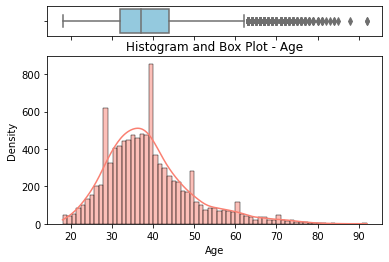

Skewness: 1.0111685586628079
Right Skewed 

Kurtosis: 1.3940495456392599
Platykurtic 

JB Test for Normality
2513.842313254128 0.0
Distribution is not normal 


Histogram and Box Plot - EstimatedSalary


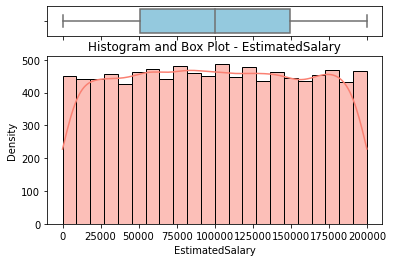

Skewness: 0.0020850448448748848
Right Skewed 

Kurtosis: -1.181527710874237
Platykurtic 

JB Test for Normality
581.677133838223 0.0
Distribution is not normal 


Histogram and Box Plot - CreditScore


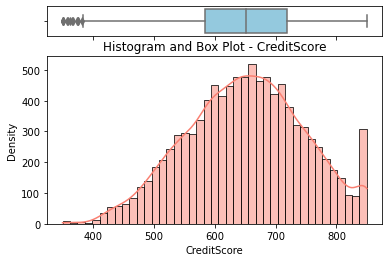

Skewness: -0.07159586676212397
Left Skewed 

Kurtosis: -0.42611279176518124
Platykurtic 

JB Test for Normality
84.19832660649816 0.0
Distribution is not normal 


Histogram and Box Plot - Balance


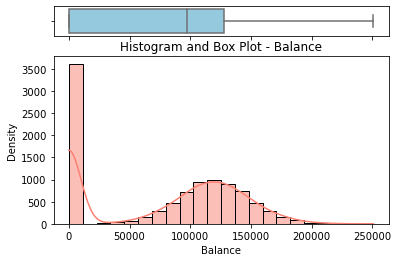

Skewness: -0.14108754375291138
Left Skewed 

Kurtosis: -1.489267106315331
Platykurtic 

JB Test for Normality
957.3080391507327 0.0
Distribution is not normal 


Histogram and Box Plot - NumOfProducts


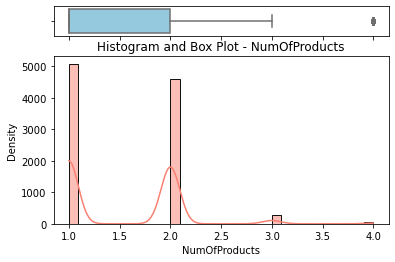

Skewness: 0.745456048438949
Right Skewed 

Kurtosis: 0.5820893733639854
Platykurtic 

JB Test for Normality
1067.3528830000523 0.0
Distribution is not normal 



In [118]:
# Box Plot & Histogram of Top 5 Important Numerical Features
master(df)

#### EDA Interpretation:

##### Class Imbalance:
There exists a class imbalance where the fully paid class (1) significantly outweighs the not fully paid class (0). In this case, the dataset is skewed towards the fully paid class. This could lead to models that are better at predicting the majority class but perform poorly on the minority class (not fully paid) which in reality also hold significant importance.

---------------------------------------------------------------------------------------------------------------------------
The pipeline uses random forest to identify top 5 most important numerical features based on its feature importance

##### Age

    1. Data is right-skewed with a skewness of 1.011.
    2. It exhibits a platykurtic distribution with a kurtosis of 1.394.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

    
##### EstimatedSalary

    1. Data is right-skewed with a skewness of 0.002.
    2. It exhibits a platykurtic distribution with a kurtosis of -1.182.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.
    
##### CreditScore

    1. Data is left-skewed with a skewness of -0.072.
    2. It exhibits a highly leptokurtic distribution with a kurtosis of -0.426..
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.
    
##### Balance

    1. Data is left-skewed with a skewness of -0.141.
    2. It exhibits a highly leptokurtic distribution with a kurtosis of -1.489. 
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

##### NumOfProducts

    1. Data is right-skewed with a skewness of 0.745.
    2. It exhibits a platykurtic distribution with a kurtosis of 0.582.
    3. The Jarque-Bera test indicates that the distribution of data significantly deviates from a normal distribution.

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 6

This function assumes that first 2 components explain significant variability in the dataset.
It then uses PCA to visualize patterns associated with class labels in a 2D plot:


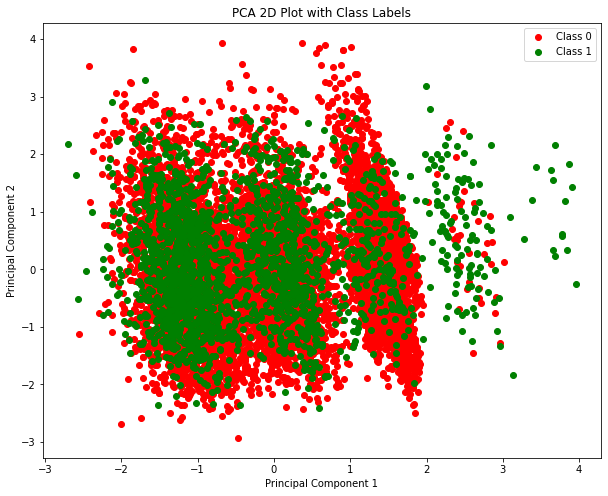

In [119]:
# Visualizing Decision Boundary Through PCA
master(df)

#### Comment:
Using the first two principal components we can visualize that there doesn't exists a distinct decision boundary that can separate and classify whether the individual has left the banking service or not as both classes seem to overlap so we can create this hypothesis that the classifiers in our project might not give extremely good accuracy and roc score due to high complexity in the dataset and a further complex model might be needed like ANN or Ensemble.

In [120]:
# Data Transformation
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 7

1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 1




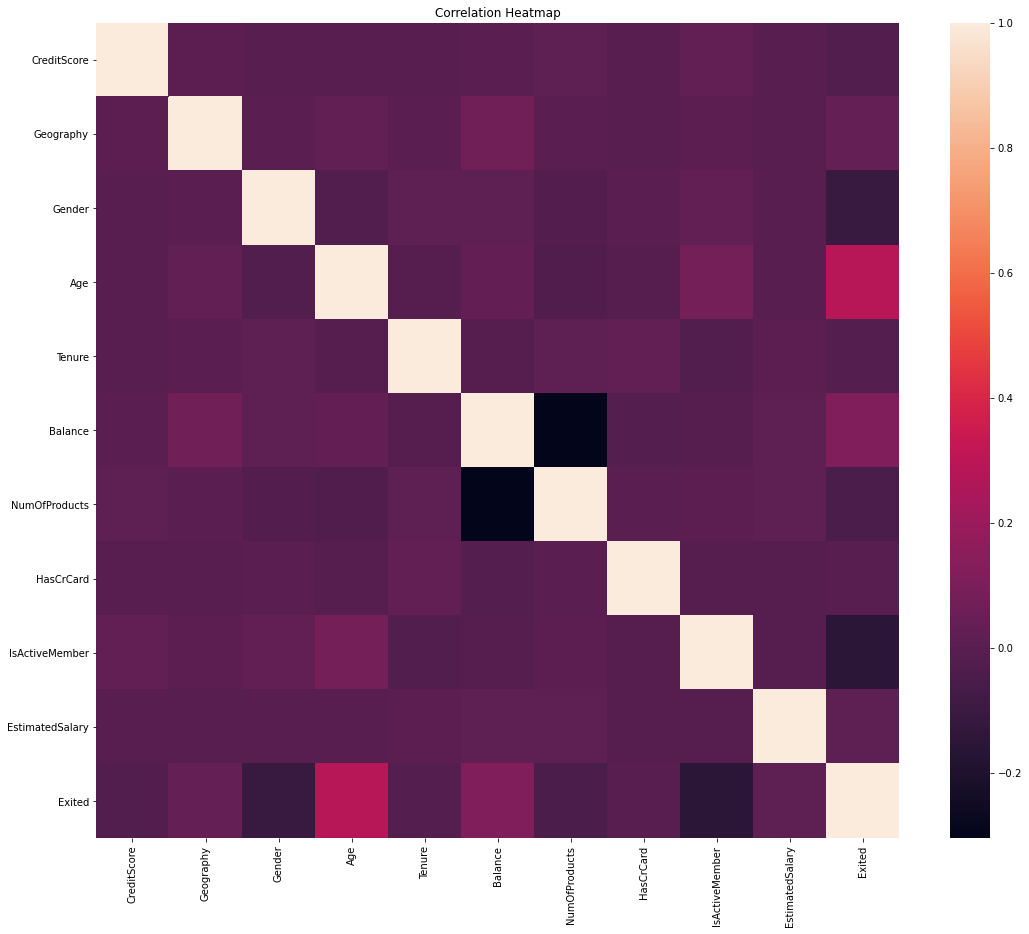


Mutual Information & Correlation of Each Feature with Target Feature
                 Mutual_Information  Correlation  Variance
Age                        0.067798     0.285341  0.999913
NumOfProducts              0.066989     0.047820  1.000891
IsActiveMember             0.015617     0.156128  0.999188
Geography                  0.013707     0.035943  1.002623
Balance                    0.009700     0.118539  1.003795
HasCrCard                  0.006597     0.007138  1.005706
CreditScore                0.005584     0.027127  0.999784
Gender                     0.005143     0.106512  1.001687
EstimatedSalary            0.004667     0.012078  1.000069
Tenure                     0.001834     0.014028  0.999805 

Type features as: 'Feature_name1,Feature_name2,Feature_name3...' 

What features to select? 'Age', 'NumOfProducts', 'IsActiveMember', 'Geography', 'Balance', 'CreditScore', 'Gender', 'EstimatedSalary'


In [121]:
# Filter Based Feature Selection
df_filter=master(df)

#### Comment:
We have selected the features that have the most mutual information and correlation with the Target Feature. Mutual information is a measure of dependence between two variables - gauges how much a feature contributes to the prediction of the target variable.For mutual information we’ve determined that the mutual information less than 0.005 translates to weak connection of a feature with target feature. Correlation explains the extent to which two features are linearly related. For our selection we've first prioritized mutual information ranking and second priority is given to correlation score because not having significant linear relationship doesn't necessarily translate to insignificant relationship.
Based on our threshold we’ve first selected features based on mutual information (from Age to EstimatedSalary) but then dropped HasCrCard due to extremely low correlation.

In [122]:
# Wrapper (Recursive) Feature Selection
df_rfs=master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 2

How many features to select? 8

Following are the 8 features selected based on the given feature selector:

Index(['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


#### Comment:
Number of feature parameter is used as a stopping criteria. Model Improvement Tolerance level would be a more accurate stopping criteria but not possible to do it through automated pipeline as there's no universal tolerance criteria as it varies for each dataset. Here number of features are set equal to filter selection number above for better comparison of different methods.

For Recursive Feature Selection we've used Random Forest Classifier with 100 trees (default). We've not used one of the models that we're using for this project in order to avoid any bias in the feature selection as feature selection through a particular model would obviously perform well for that model in comparison to other models. Besides, feature selection based on 100 trees would also render a more robust choice.

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 3


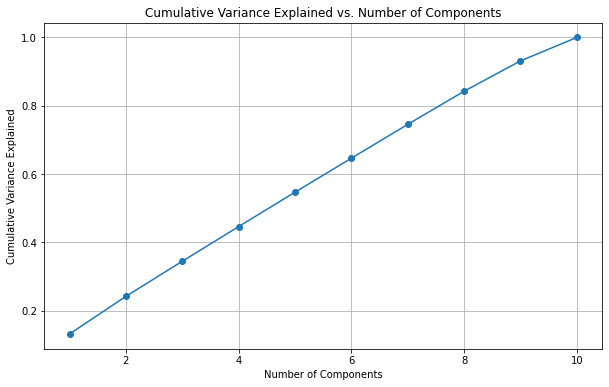


Enter the number of components for PCA: 9


In [123]:
# Feature Selection Through PCA
df_pca=master(df)

#### Comment:
Since first 9 components explain more than 90% variability in the dataset, we've selected first 9 components as feature subset. Increasing the number of components increases cumulative variance but after 9 components, it's of no use as the number of features would be equal to those in orignal dataset.

In [124]:
# Comparison of Different Feature Selection Methods
res=master([df,df_filter,df_rfs,df_pca])
pd.DataFrame(res)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 8

1- Filter Methods
2- Wrapper Method (RFS)
3- Dimensionality Reduction (PCA)
4- Feature Selection Evaluation
Which type of method? 4


,No FS,Filter FS,Recursive FS,PCA FS
KNN Classifier,0.830000,0.833333,0.848000,0.815333
Logistic Regression,0.804667,0.804000,0.809333,0.806000
Naive Bayes Classifier,0.824000,0.824000,0.825333,0.814000
Linear SVC,0.802000,0.801333,0.802000,0.807333
Decision Trees,0.778000,0.774000,0.787333,0.755333


#### Comment:
Selected Feature Subet: Recursive Feature Selection Subset

For comparison we've split the data into 3 sets (train/val/test:70/15/15) and train each model with each feature subset on the training data and computed accuracy of the model on the validation set. We've not used test set as it is supposed to be unseen data and using it for feature selection might cause data leakage and make model less generalizable eventually. 

Overall Feature Subset selected through Recursive Feature Selection gives the best accuracy for most of the models. So we'll continue our analysis using this feature subset.

In [125]:
# Data Splitting & CV Strategy
X_train,X_val,X_test,y_train,y_val,y_test,sk_folds=master(df_rfs)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10


#### Comment:
We've used 70% data for training and 15% each for validation and testing. Since our dataset has 10000 rows, it's sufficient to test the model on only 15% of the data.

For Cross-Validation (CV), we've used used Stratified k-fold CV with 10 folds as our strategy since 10 folds is industry norm and stratification ensures that each fold preserves the same class distribution as the original dataset which is particularly important when dealing with imbalanced datasets like one we have.

In [126]:
# Initial Model Learning & Hyperparameters Tuning
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 10


{'KNN': {'n_neighbors': 13, 'p': 2},
 'Logistic Regression': {'C': 0.001, 'penalty': 'l2'},
 'Linear SVC': {'C': 0.0001, 'loss': 'squared_hinge'},
 'Decision Tree': {'max_depth': 7, 'min_samples_leaf': 12},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

#### Comment:
We've first trained the models on 70% of the dataset and tuned hyperparameters of the model on the 15% of data. Because our dataset has high class imbalance we've used auc score rather than accuracy score for evaluating the model on the validation set to pick the best hyperparameters. We've tested the following values of the hyperparameters:

##### knn_grid={'n_neighbors': [5, 7, 9, 11, 13], 'p': [1, 2, 3]}

We've tested number of neighbors to use for classification and whether distance metric used should be manhattan, euclidean, or minkowski with p=3.

##### lgr_grid={'C': [0.0001, 0.001, 0.01, 0.1], 'penalty': ['l1', 'l2']}

We've tested which penalty method to use to avoid overfitting by reducing impact of some features. L1-Lasso (some coefficients become exactly zero) or L2-Ridge (coefficient become closer to zero but not exactly). We've also tested C which determines the magnitude by which to penalize where smaller values of C result in stronger regularization, meaning the model will be penalized more for having large coefficients and therefore less overfit but we've to find right value of C so we don't underfit as well.

##### svc_grid={'C': [0.00001,0.0001, 0.001, 0.01], 'loss': ['hinge', 'squared_hinge']}

We've here tested different values of C which is again penalty term and smaller value of C means strong regularization. The higher the C, the more likely it'll fit closely to training data and won't allow misclassification with the margin. We've also tested different loss functions which are used to maximize margin.

##### dt_grid={'max_depth': [3, 7, 10, None], 'min_samples_leaf': [2, 5, 12]}

We've tested different levels of tree depth with lower depth meaning a tree that is more likely to generalize well whereas a deeper tree is more likely to learn data well but also prone to overfit so we've used validation set to find the correct depth. We've also tested different values of minimum samples required for a node to be considered for further splitting. A higher value can prevent the tree from splitting nodes that have few samples, potentially reducing overfitting.

Note: Naive Bayes Classifier has no hyperparameters to tune!

In [127]:
# Final Model Learning & Evaluation (Baseline Execution)
baseline=master(data=df_rfs,hyperparameters=hyperparameters,sk_folds=sk_folds)
baseline

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.857788,0.804408,0.801370,0.871067,0.824487
Precision (class 1),0.730994,0.625000,0.600000,0.741117,0.758621
Recall (class 0),0.961214,0.984823,0.986509,0.956998,0.982293
Recall (class 1),0.398089,0.095541,0.076433,0.464968,0.210191
F1-score (class 0),0.906561,0.885519,0.884354,0.912013,0.896499
F1-score (class 1),0.515464,0.165746,0.135593,0.571429,0.329177
Testing Accuracy,0.843333,0.798667,0.796000,0.854000,0.820667
Training Accuracy,0.866471,0.801412,0.800824,0.861765,0.827882
AUC,0.819944,0.760550,0.761514,0.839428,0.798536
Testing Accuracy CV,0.850400,0.801300,0.799700,0.858000,0.826900


#### Comment:
After finding the best hyperparameters we've again trained the model on 85% of the data (on both training and validation set combined) and finally evaluated it on 15% of the data. For fixed feature selection subset, cv strategy, and train-validation-test split we've done baseline execution on our imbalanced data for all algorithms and recorded all of the initially selected performance metrics.

Note: Results Interpretation is given at the end with comparison of baseline execution against class imbalance techniques.

## Class Imbalance Solutions Application

For consistency in comparison, we've kept the following fixed for each class imbalance solution approach as per our baseline execution:

#### Train/Validation/Test Split:
Train/Validation/Test split size is kept same as baseline execution in the ratio of 70:15:15. Same test set of the baseline execution is used for model evaluation of each class imbalance solution approach.
#### Feature Selection:
Best feature subset, which is the one that is selected through Recursive Feature Selection in the baseline execution, is also used here for each class imbalance solution approach. Following were the features selected through Recursive Feature Selection in the baseline execution:

Index(['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico','days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'not.fully.paid'], dtype='object')
#### CV Strategy:
CV Strategy of Stratified 10-fold Cross Validation employed in the baseline execution is also kept constant for each class imbalance solution approach.

Note: We've not fixed hyperparameters but retuned them because while maintaining consistency is important, it's also important that the comparison is fair and while previous hyperparameters were tuned to an imbalanced dataset, it's crucial to tune hyperparameters for a balanced set and then compare the results to isolate the impact of effectiveness of applied class imbalance solution technique.

In [128]:
# Data Preprocessing
df=master()
label_column="Exited"
# Manually Dropping Irrelevant Features
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)
master(df)
master(df)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 1

Please enter the source path: C:/Users/H-L-LAPTOP/Churn_Modelling.csv
Successfuly Connected to the Data Source
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11-

In [129]:
## ADASYN Application
df_ADASYN=ADA(df)
master(df_ADASYN)
# df.to_csv("Churn_Modelling_ADASYN.csv",index=False)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 2
Dataset is treated for duplicated values successfully


In [130]:
print(master(df_ADASYN),'\n')
print("Size After ADASYN Treatment")
print(df_ADASYN.shape,'\n')
print('Size Before Treatment')
print(df.shape)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3
0    50.421126
1    49.578874
Name: Exited, dtype: float64 

Size After ADASYN Treatment
(15791, 11) 

Size Before Treatment
(10000, 11)


In [131]:
# Retuning hyperparameters on balanced dataset (Keeping FS, Train-Validation-Test Split Same, & constant CV Strategy)
df_ADASYN=df_ADASYN[df_rfs.columns]
X_train,X_val,nouse1,y_train,y_val,nouse2,sk_folds=master(df_rfs)
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tu

{'KNN': {'n_neighbors': 13, 'p': 2},
 'Logistic Regression': {'C': 0.001, 'penalty': 'l2'},
 'Linear SVC': {'C': 0.0001, 'loss': 'squared_hinge'},
 'Decision Tree': {'max_depth': 7, 'min_samples_leaf': 12},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

In [132]:
adas=master(data=df_ADASYN,hyperparameters=hyperparameters,sk_folds=sk_folds,X_test=X_test,y_test=y_test,ci='Yes')
adas

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.956197,0.900114,0.899772,0.928352,0.911602
Precision (class 1),0.484043,0.365105,0.363344,0.466539,0.393277
Recall (class 0),0.754637,0.668634,0.666105,0.764755,0.695616
Recall (class 1),0.869427,0.719745,0.719745,0.777070,0.745223
F1-score (class 0),0.843544,0.767296,0.765504,0.838650,0.789096
F1-score (class 1),0.621868,0.484459,0.482906,0.583035,0.514851
Testing Accuracy,0.778667,0.679333,0.677333,0.767333,0.706000
Training Accuracy,0.831545,0.670317,0.669945,0.790344,0.708315
AUC,0.908699,0.760921,0.760303,0.861865,0.811369


In [133]:
## KMeansSMOTE Application
df_KSMO=KSMO(df)
master(df_KSMO)
# df.to_csv("Churn_Modelling_KMeansSMOTE.csv",index=False)

C:\Users\H-L-LAPTOP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 2
Dataset is treated for duplicated values successfully


In [134]:
print(master(df_KSMO),'\n')
print("Size After KMeansSMOTE Treatment")
print(df_KSMO.shape,'\n')
print('Size Before Treatment')
print(df.shape)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3
1    50.015695
0    49.984305
Name: Exited, dtype: float64 

Size After KMeansSMOTE Treatment
(15929, 11) 

Size Before Treatment
(10000, 11)


In [135]:
# Retuning hyperparameters on balanced dataset (Keeping FS, Train-Validation-Test Split Same, & constant CV Strategy)
df_KSMO=df_KSMO[df_rfs.columns]
X_train,X_val,nouse1,y_train,y_val,nouse2,sk_folds=master(df_rfs)
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tu

{'KNN': {'n_neighbors': 13, 'p': 2},
 'Logistic Regression': {'C': 0.001, 'penalty': 'l2'},
 'Linear SVC': {'C': 0.0001, 'loss': 'squared_hinge'},
 'Decision Tree': {'max_depth': 7, 'min_samples_leaf': 12},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

In [136]:
smot=master(data=df_KSMO,hyperparameters=hyperparameters,sk_folds=sk_folds,X_test=X_test,y_test=y_test,ci='Yes')
smot

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.941634,0.888052,0.886241,0.916514,0.904025
Precision (class 1),0.538136,0.367776,0.362218,0.543902,0.416196
Recall (class 0),0.816189,0.695616,0.689713,0.842327,0.738617
Recall (class 1),0.808917,0.668790,0.665605,0.710191,0.703822
F1-score (class 0),0.874435,0.780142,0.775723,0.877856,0.812993
F1-score (class 1),0.646310,0.474576,0.469136,0.616022,0.523077
Testing Accuracy,0.814667,0.690000,0.684667,0.814667,0.731333
Training Accuracy,0.862028,0.709654,0.708324,0.838319,0.736022
AUC,0.896908,0.757935,0.757444,0.858886,0.801313


In [137]:
# Deep Learning Application
# Deep Learning Data Generator Source: app.mostly.ai
status_mapping={0:'No',1:'Yes'}
df[label_column]=df[label_column].map(status_mapping)
#df.to_csv("df_clean.csv",index=False)
df_DL=master()
master(df_DL)
status_mapping_reverse={'No':0,'Yes':1}
df_DL[label_column]=df_DL[label_column].map(status_mapping_reverse)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 1

Please enter the source path: C:/Users/H-L-LAPTOP/Churn_Modelling_DL.csv
Successfuly Connected to the Data Source
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning


In [138]:
print(master(df_DL),'\n')
print("Class Size After Deep Learning Data Generation Treatment")
print(df_DL.shape)

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 3
1    50.015832
0    49.984168
Name: Exited, dtype: float64 

Class Size After Deep Learning Data Generation Treatment
(15791, 11)


#### Comment:
Through Deep Learning Data Generators, we've generated synthetic data of same size as ADASYN dataset and balanced classes. Now the dataset has class imbalance ratio rougly 50:50.

Note: In this case, we're training a model on a completely synthetic data rather than oversampled data with some synthetic data points.

In [139]:
# Retuning hyperparameters on balanced dataset (Keeping FS, Train-Validation-Test Split Same, & constant CV Strategy)
df_DL=df_DL[df_rfs.columns]
X_train,X_val,nouse1,y_train,y_val,nouse2,sk_folds=master(df_DL)
hyperparameters=master(X_train=X_train,X_val=X_val,y_train=y_train,y_val=y_val)
hyperparameters

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 9

What % of data to be left for test? 15
What % of data to be left for validation? 15

How many folds required for CV? 10
1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tu

{'KNN': {'n_neighbors': 13, 'p': 3},
 'Logistic Regression': {'C': 0.01, 'penalty': 'l1'},
 'Linear SVC': {'C': 0.01, 'loss': 'hinge'},
 'Decision Tree': {'max_depth': 7, 'min_samples_leaf': 12},
 'Naive Bayes Classifier': 'No Hyperparameters to Tune!'}

In [140]:
dl=master(data=df_DL,hyperparameters=hyperparameters,sk_folds=sk_folds,X_test=X_test,y_test=y_test,ci='Yes')
dl

1- Load Data
2- Data Cleaning (Missing & Duplicate Values Treatment)
3- EDA: Class Balance(%)
4- EDA: Numerical Summary
5- EDA: Histogram & Box Plot of Important Numerical Features
6- EDA: PCA Visualization
7- Data Transformation (Categorical Encoding & Standardization)
8- Feature Selection
9-  Train-Validation-Test Splitting & Stratified Cross-Validation
10- Initial Model Training & Hyperparameter Tunning
11- Final Model Training & Evaluation

What do you want to do? 11


,KNN,Logistic Regression,Linear SVC,Decision Tree,Naive Bayes
Precision (class 0),0.919840,0.902977,0.896118,0.927052,0.897939
Precision (class 1),0.466135,0.381113,0.393053,0.471735,0.436590
Recall (class 0),0.774030,0.690556,0.720067,0.771501,0.771501
Recall (class 1),0.745223,0.719745,0.684713,0.770701,0.668790
F1-score (class 0),0.840659,0.782609,0.798504,0.842154,0.829932
F1-score (class 1),0.573529,0.498346,0.499419,0.585248,0.528302
Testing Accuracy,0.768000,0.696667,0.712667,0.771333,0.750000
Training Accuracy,0.757860,0.662792,0.666667,0.750484,0.695649
AUC,0.839771,0.764704,0.765003,0.853568,0.799121


#### Combined Results

In [141]:
print("Baseline")
print("-"*109)
print(tabulate(baseline,headers='keys',tablefmt='psql'),"\n\n")

print("CI Solution # 1: ADASYN")
print("-"*107)
print(tabulate(adas,headers='keys',tablefmt='psql'),"\n\n")

print("CI Solution # 2: KMeansSMOTE")
print("-"*107)
print(tabulate(smot,headers='keys',tablefmt='psql'),"\n\n")

print("CI Solution # 3: Deep Learning Generator")
print("-"*107)
print(tabulate(dl,headers='keys',tablefmt='psql'),"\n\n")

Baseline
-------------------------------------------------------------------------------------------------------------
+---------------------+----------+-----------------------+--------------+-----------------+---------------+
|                     |      KNN |   Logistic Regression |   Linear SVC |   Decision Tree |   Naive Bayes |
|---------------------+----------+-----------------------+--------------+-----------------+---------------|
| Precision (class 0) | 0.857788 |             0.804408  |    0.80137   |        0.871067 |      0.824487 |
| Precision (class 1) | 0.730994 |             0.625     |    0.6       |        0.741117 |      0.758621 |
| Recall (class 0)    | 0.961214 |             0.984823  |    0.986509  |        0.956998 |      0.982293 |
| Recall (class 1)    | 0.398089 |             0.0955414 |    0.0764331 |        0.464968 |      0.210191 |
| F1-score (class 0)  | 0.906561 |             0.885519  |    0.884354  |        0.912013 |      0.896499 |
| F1-score (class

#### Result Interpretation:

#### Baseline Results:
1. The baseline models demonstrate significant class imbalance issues, especially in terms of recall, and F1-score for the minority class (class 1). Precision for the minority class 1 varies but generally lower than majority 0 class, suggesting a higher false positive rate for predicting the minority class.
2. Recall for class 1 is low across all models, indicating that the models are missing a large number of positive instances.
3. F1-scores for class 0 are notably higher compared to class 1, indicating better overall performance for the majority class
4. Testing accuracy is decent which is to be expected as due to imbalance data almost 80% is majority class.
5. AUC scores are relatively good, indicating good discriminative ability between the two classes.

#### CI Solution #1: ADASYN:
1. Precision for class 1 has marjinally decreased compared to the baseline for all models. This indicates that while ADASYN may have improved the model's ability to capture more instances of the minority class, it has also increased the number of false positives, which negatively impacts precision.
2. Recall for class 1 has drastically improved, suggesting much better identification of positive cases after applying ADASYN.
3. F-1 score for class 1 has generally improved.
4. Testing accuracy has declined slightly as that understandable because of imbalance data and 80% majority class in baseline.
5. AUC across all model shows improvement indicating better distiction between two classes after ADAYSN

#### CI Solution #2: KMeansSMOTE:
1. Precision for class 1 has marjinally decreased compared to the baseline for all models which is similar to ADASYN. This indicates that while KMeansSMOTE may have improved the model's ability to capture more instances of the minority class, it has also increased the number of false positives, which negatively impacts precision.
2. Recall for class 1 has drastically improved same as ADASYN, suggesting much better identification of positive cases after applying KMeansSMOTE.
3. F-1 score for class 1 has generally improved same as ADASYN.
4. Testing accuracy has declined slightly as that understandable because of imbalance data and 80% majority class in baseline.
5. AUC across all model shows improvement indicating better distiction between two classes after KMeansSMOTE similar to ADASYN.

#### CI Solution #3: Deep Learning Generator:
1. Precision for class 1 has marjinally decreased compared to the baseline for all models which is similar to ADASYN & KMeansSMOTE. This indicates that while Deep Learning Generator may have improved the model's ability to capture more instances of the minority class, it has also increased the number of false positives, which negatively impacts precision.
2. Recall for class 1 has drastically improved same as ADASYN & KMeansSMOTE, suggesting much better identification of positive cases after applying Deep Learning Generator.
3. F-1 score for class 1 has generally improved same as ADASYN & KMeansSMOTE.
4. Testing accuracy has declined slightly as that understandable because of imbalance data and 80% majority class in baseline.
5. AUC across all model shows improvement indicating better distiction between two classes after Deep Learning Generator similar to ADASYN & KMeansSMOTE.

#### General Observations:
1. Here the we can see All class imbalance solutions have led to same results across all models i.e Precision and Testing Accuracy decreasing and Recall, F-1 score and AUC increasing following similar trend across all solutions and models.
2. The choice between ADASYN, KMeansSMOTE, and deep learning-based approaches should consider the specific characteristics of the dataset available. for eg in above done PCA we can see non linear boundary data sets hence the ADASYN generally out performs All the CI and Baseline if we compare it with rest of the results specially in terms of AUC and Recall. specifically if you compare KNN model.
3. Also note that compared to rest of models KNN shows far better performance in AUC for ADASYN and KMeansSMOTE maybe due to the characterstics of data handling of these two CI method.